In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.random.seed(2024)

[nltk_data] Downloading package punkt to /Users/andrewye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewye/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Executive Summary 
This project analyzes how the overall socioeconomic status impacts the volume of Improve Detroit (similar to 311) requests that people make in different neighborhoods. Individuals typically submit requests for public infrastructure issues, such as curbside debris removal, potholes, and traffic signs needing repairs. Each neighborhood is divided based on US zip codes, focusing on debris-related requests. Socioeconomic information was obtained from uszipcode.org (based on the 2020 Census Bureau Survey and 2021 American Communities Survey), and Improve Detroit requests and vacant property data were collected from the Detroit Open Data Portal between 2019/01/03 to 2023/02/21. The Zillow Housing Value Index was sourced from zillow.com.

Using OLS regression, the analysis found that new vacant property is most strongly associated with requests per resident (the dependent variable). Median earnings from the previous year (2021) and home values (from both the Census Bureau and Zillow) also show a strong negative association with requests per resident, with p-values under 0.05. Additionally, the analysis suggests that a higher educational level (defined as the percentage of bachelor’s degree holders) contributes to the decrease of debris-related requests (p-value: 0.068). However, higher gross rent does not impact the number of debris-related incidents, nor does the percent of poverty.

A model using Median earnings from the last year and new vacant properties was fitted (Adjusted R^2 0.613), and these two variables are strong predictors of requests per resident within a zip code. Individuals’ higher earnings have a significant effect on decreasing the number of debris-related incidents. Higher home values have similar effects (the two are highly correlated), but median earnings proved to be a better predictor in this model.

**Limitations**

Due to the data collection methods used by the City of Detroit, it is not possible to effectively distinguish between requests submitted by city workers and those made by residents. Therefore, analyzing how residents contribute to the total volume of requests is challenging. Additionally, the focus was solely on debris-related requests, which may overlook potential trends in other types of requests. While median earnings from the previous year showed a strong negative association in decreasing requests per resident, the median household income did not. Future projects should investigate the cause of this discrepancy.

The analysis is structured into three sections. First, I examine the requests to understand 1. the types of requests people are making and any issues/patterns to note, and 2. the specific types of requests to focus on. Then we proceed to analyze the neighborhoods to 1. comprehend the characteristics of different areas and 2. identify potential confounding variables. Finally, we investigate how socioeconomic status affects the 311 requests. The full methodology can be found below.


<table>
  <tr>
    <td><img src="viz/ipr_zip.png" alt="irp_zip" /></td>
  </tr>
</table>

## Section 1: Extracting Information from Improve Detroit Dataset

In this section, I selected five debris-related requests out of all possible requests to focus on.

In [2]:
# Load the Improve Detroit data
detroit_ip_original = pd.read_csv('data/Improve_Detroit_Issues_2024_p.csv', low_memory=False)
detroit_ip_original.columns

Index(['X', 'Y', 'ID', 'Status', 'Request_Type_Title', 'Description',
       'Web_Url', 'Report_Method', 'Priority_Code', 'Created_At',
       'Acknowledged_At', 'Closed_At', 'Reopened_At', 'Updated_At',
       'Days_to_Close', 'Canonical_Issue_ID', 'Address', 'Neighborhood',
       'Council_District', 'Latitude', 'Longitude', 'Address_ID', 'ObjectId',
       'Zip_Code'],
      dtype='object')

In [3]:
# Convert to small case
detroit_ip_original.columns = detroit_ip_original.columns.str.lower()

In [4]:
detroit_ip_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513460 entries, 0 to 513459
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   x                   469505 non-null  float64
 1   y                   469505 non-null  float64
 2   id                  513460 non-null  int64  
 3   status              513460 non-null  object 
 4   request_type_title  513460 non-null  object 
 5   description         427440 non-null  object 
 6   web_url             513460 non-null  object 
 7   report_method       513460 non-null  object 
 8   priority_code       513460 non-null  int64  
 9   created_at          513460 non-null  object 
 10  acknowledged_at     482998 non-null  object 
 11  closed_at           480412 non-null  object 
 12  reopened_at         6825 non-null    object 
 13  updated_at          513460 non-null  object 
 14  days_to_close       480412 non-null  float64
 15  canonical_issue_id  14991 non-null

In [5]:
detroit_ip_original.head()

,x,y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,days_to_close,canonical_issue_id,address,neighborhood,council_district,latitude,longitude,address_id,objectid,zip_code
0,-83.025585,42.445666,16051796,Open,Abandoned Vehicle - On Street,Several non running vehicles parked: in front...,https://seeclickfix.com/issues/16051796,direct,2,2024/02/14 00:19:35+00,...,NaN,NaN,"20242 Stotter St Detroit, MI 48234, USA",Sherwood,3.0,42.445666,-83.025585,268881.0,1,48234.0
1,-82.958956,42.423553,16051674,Acknowledged,Investigate Water Main Break,water main break,https://seeclickfix.com/issues/16051674,direct,2,2024/02/13 23:03:48+00,...,NaN,NaN,"11907 Riad St Detroit, MI 48224, USA",Denby,4.0,42.423553,-82.958956,295764.0,2,48224.0
2,-83.012240,42.354894,16051658,Open,Potholes,Potholes in street big enough to warrant drivi...,https://seeclickfix.com/issues/16051658,direct,2,2024/02/13 22:54:13+00,...,NaN,NaN,"2156 Bellevue St Detroit MI 48207, United States",Islandview,5.0,42.354894,-83.012240,330068.0,3,48207.0
3,-83.216401,42.399612,16051327,Open,Potholes,several bad potholes on the south side of Gran...,https://seeclickfix.com/issues/16051327,direct,2,2024/02/13 20:31:06+00,...,NaN,NaN,"17675 W Grand River Ave Detroit, MI 48227, USA",Grandmont,1.0,42.399612,-83.216401,147115.0,4,48227.0
4,-82.951146,42.409330,16051228,Acknowledged,Curbside Solid Waste Issue,Yard waste is not scheduled to be picked up in...,https://seeclickfix.com/issues/16051228,direct,2,2024/02/13 20:02:59+00,...,NaN,NaN,"15801 Evanston St Detroit MI 48224, United States",Outer Drive-Hayes,4.0,42.409330,-82.951146,298674.0,5,48224.0


In [6]:
detroit_ip_original.tail()

,x,y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,days_to_close,canonical_issue_id,address,neighborhood,council_district,latitude,longitude,address_id,objectid,zip_code
513455,-83.032690,42.343270,1328320,Archived,Running Water in a Home or Building,On south bound st. Aubin street drains blocked...,https://seeclickfix.com/issues/1328320,direct,2,2014/10/19 07:31:59+00,...,11.113345,NaN,"1849-1999 St Aubin St Detroit, Michigan",Lafayette Park,5.0,42.343270,-83.032690,NaN,513456,48207.0
513456,-83.022549,42.356131,1327216,Archived,Tree Issue,"34"" S maple down blocking walk",https://seeclickfix.com/issues/1327216,direct,2,2014/10/17 14:22:11+00,...,3.006250,NaN,"3424 Arndt St Detroit, Michigan",McDougall-Hunt,5.0,42.356131,-83.022549,433710.0,513457,48207.0
513457,-83.071642,42.330154,1327050,Archived,Running Water in a Home or Building,Running water on outside of building north of ...,https://seeclickfix.com/issues/1327050,direct,2,2014/10/17 12:20:49+00,...,14.044421,NaN,"2051 Rosa Parks Blvd Detroit, Michigan",Corktown,6.0,42.330154,-83.071642,348599.0,513458,48216.0
513458,-83.268672,42.441045,1325862,Archived,Tree Issue,Tree fallen Blocking Street,https://seeclickfix.com/issues/1325862,direct,2,2014/10/16 18:14:20+00,...,12.865185,NaN,22930 Hessel,Berg-Lahser,1.0,42.441045,-83.268672,104893.0,513459,48219.0
513459,-83.125836,42.328863,1325702,Archived,Tree Issue,Both traffic signal heads for northbound Marti...,https://seeclickfix.com/issues/1325702,direct,2,2014/10/16 15:36:47+00,...,116.691655,NaN,"4000-4098 Martin Road Detroit, Michigan",Michigan-Martin,6.0,42.328863,-83.125836,NaN,513460,48210.0


In [7]:
detroit_ip_original.describe()

,x,y,id,priority_code,days_to_close,canonical_issue_id,council_district,latitude,longitude,address_id,objectid,zip_code
count,469505.000000,469505.000000,5.134600e+05,513460.000000,480412.000000,1.499100e+04,512594.000000,469505.000000,469505.000000,395344.000000,513460.000000,512594.000000
mean,-83.116360,42.387921,8.343547e+06,1.999965,41.618363,8.332731e+06,4.127009,42.387921,-83.116360,220058.166189,256730.500000,48219.552820
std,0.098106,0.037322,4.315242e+06,0.011508,110.095431,4.507980e+06,2.103313,0.037322,0.098106,141701.287755,148223.278946,11.093203
min,-86.550059,41.879952,1.184398e+06,1.000000,0.000035,1.400000e+01,1.000000,41.879952,-86.550059,1.000000,1.000000,48201.000000
25%,-83.201662,42.359395,4.314043e+06,2.000000,3.181568,3.871110e+06,2.000000,42.359395,-83.201662,111094.750000,128365.750000,48210.000000
50%,-83.130750,42.390331,8.284580e+06,2.000000,10.045041,8.267452e+06,4.000000,42.390331,-83.130750,190589.000000,256730.500000,48221.000000
75%,-83.039170,42.419331,1.214965e+07,2.000000,30.272827,1.291297e+07,6.000000,42.419331,-83.039170,312532.000000,385095.250000,48228.000000
max,-82.910772,42.490537,1.605180e+07,3.000000,2568.822743,1.603214e+07,7.000000,42.490537,-82.910772,549797.000000,513460.000000,48243.000000


In [8]:
# X and Longitude, Y and Latitude seem to be the same thing.
print((detroit_ip_original[detroit_ip_original.x.notna()]["x"] == detroit_ip_original[detroit_ip_original.longitude.notna()]["longitude"]).value_counts())
print((detroit_ip_original[detroit_ip_original.y.notna()]["y"] == detroit_ip_original[detroit_ip_original.latitude.notna()]["latitude"]).value_counts())

True    469505
Name: count, dtype: int64
True    469505
Name: count, dtype: int64


In [9]:
# Some requests were updated long after being closed.
updated_after_close_condition = detroit_ip_original['updated_at'] > detroit_ip_original['closed_at']
detroit_ip_original[updated_after_close_condition].sample(n = 15, random_state=2024)
# Clicked these URLs and I found that most of the time there are no actual "updates". There could be other reasons they updated something, but it is not helpful for this analysis.

,x,y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,days_to_close,canonical_issue_id,address,neighborhood,council_district,latitude,longitude,address_id,objectid,zip_code
408425,NaN,NaN,3733257,Archived,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/3733257,direct,2,2017/09/26 15:09:01+00,...,6.736354,NaN,Redacted,Farwell,3.0,NaN,NaN,NaN,408426,48234.0
270070,-83.071625,42.371857,7758157,Closed,Cave-In over the Sewer,The pavement around this manhole has sunk down...,https://seeclickfix.com/issues/7758157,direct,2,2020/05/04 18:15:33+00,...,833.788426,NaN,"7355–7399 John R St Detroit 48202, United States",North End,5.0,42.371857,-83.071625,NaN,270071,48202.0
198284,-83.147384,42.440052,9923175,Closed,DPW - Debris Removal - DPW USE ONLY,DEBRIS ON BERM,https://seeclickfix.com/issues/9923175,internal,2,2021/05/15 11:57:42+00,...,5.183472,NaN,"20004 San Juan Dr Detroit, MI, 48221, USA",Garden Homes,2.0,42.440052,-83.147384,421072.0,198285,48221.0
193722,-83.068619,42.330417,10076820,Archived,Tree Issue,Tree Branch down1628 church street,https://seeclickfix.com/issues/10076820,direct,2,2021/06/07 09:20:19+00,...,1.239167,NaN,"1628 Church St Detroit MI 48216, United States",Corktown,6.0,42.330417,-83.068619,238906.0,193723,48216.0
430863,-83.074436,42.338266,3398013,Archived,Illegal Dump Sites,Corner lot Elm and Harrison lot has grass wais...,https://seeclickfix.com/issues/3398013,direct,2,2017/05/08 23:33:52+00,...,2.586447,NaN,"3045 Harrison Street Detroit, Michigan",North Corktown,6.0,42.338266,-83.074436,NaN,430864,48216.0
369246,-83.232470,42.431218,4658875,Archived,DPW - Debris Removal - DPW USE ONLY,"Burned, dilapidated trailer filled with garbage.",https://seeclickfix.com/issues/4658875,direct,2,2018/07/10 11:02:11+00,...,8.927037,NaN,"19201 Grandville Avenue Detroit, MI",O'Hair Park,1.0,42.431218,-83.232470,115663.0,369247,48219.0
39041,-83.132905,42.352026,14789355,Closed,Potholes,MASSIVE CAR DESTROYIMG BOMB CRATERS,https://seeclickfix.com/issues/14789355,direct,2,2023/06/28 10:32:29+00,...,4.912014,NaN,"6100 Tireman Ave Detroit, MI 48204, USA",Midwest,6.0,42.352026,-83.132905,400214.0,39042,48204.0
500066,-83.074897,42.358588,1760814,Archived,Tree Issue,The tree is very overgrown so far that it almo...,https://seeclickfix.com/issues/1760814,direct,2,2015/07/08 23:12:18+00,...,287.783067,NaN,"John C Lodge Freeway & Interstate 94 Detroit, ...",Wayne State,6.0,42.358588,-83.074897,NaN,500067,48202.0
456598,-83.184560,42.435912,2949167,Archived,Curbside Solid Waste Issue,NaN,https://seeclickfix.com/issues/2949167,phone,2,2016/09/28 15:43:49+00,...,5.936273,NaN,"19485 Stansbury Avenue Detroit, MI",Schaefer 7/8 Lodge,2.0,42.435912,-83.184560,21377.0,456599,48235.0
443650,NaN,NaN,3207222,Archived,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/3207222,direct,2,2017/02/13 23:33:38+00,...,2.574850,NaN,Redacted,Conner Creek,3.0,NaN,NaN,NaN,443651,48205.0


### 1.1 Understand Values in Different Columns

I examined different values and also determined which of them are useful for the questions.

In [10]:
interesting_columns = ['status', 'request_type_title', 'report_method', 'priority_code', 'neighborhood', 'council_district', 'address_id', 'zip_code']

for col in interesting_columns:
    print(f"Value counts for column: {col}")
    print(detroit_ip_original[col].value_counts())
    print("-" * 40)

Value counts for column: status
status
Archived        344208
Closed          150567
Acknowledged     16751
Open              1934
Name: count, dtype: int64
----------------------------------------
Value counts for column: request_type_title
request_type_title
DPW - Debris Removal - DPW USE ONLY                80930
Illegal Dump Sites                                 52384
DPW - Other environmental - DPW USE ONLY           52208
Curbside Solid Waste Issue                         45452
Abandoned Vehicle                                  39966
                                                   ...  
Vacant Service Leak                                   13
Graffiti Abatement - Major Project                    12
PDU Maintenance                                       10
Investigate Water In Basement (Basement Backup)        3
Clogged Drain                                          1
Name: count, Length: 71, dtype: int64
----------------------------------------
Value counts for column: report_m

#### Observations
1. The majority of cases in my dataset are marked as “Archived” or “Closed,” and my analytical focus will be on these already processed cases. Thus, statuses such as “Acknowledged” and “Open” will be disregarded in later stages.
2. I have identified 71 different types of service requests. I intend to concentrate on the most common ones, eventually omitting infrequent types like “Clogged Drain,” which accounts for a solitary incident.
3. The app is the primary platform for reporting most cases, with only a small fraction originating from social media or public meetings.
4. Only 0.00013% of cases have a priority code other than 2, suggesting that priority codes offer limited analytical utility.
5. There are 207 neighborhoods in Detroit—far more than the number of zip codes I have.
6. Council District 7 has significantly more cases than other districts. The last redistricting was in 2012, and the next new map will be in effect in 2026. This is not a factor.
7. Address_ID seems to be associated with a particular street address and will require more investigation later.
8. As mentioned earlier, the existence of “updated_at” does not actually reflect an “update.”

Below is a table of what variables we plan to keep or drop after this section

| Variables          | Selected    | Notes                                                                                                      |
|--------------------|-------------|------------------------------------------------------------------------------------------------------------|
| x                  | Drop        | Duplicates of Longitude                                                                                    |
| y                  | Drop        | Duplicates of Latitude                                                                                     |
| id                 | Selected    | Index                                                                                                      |
| status             | Drop Later  | I will select cases that are either "archived" or "closed".                                                |
| request_type_title | Selected    |                                                                                                            |
| description        | Selected    | I will use this to understand some requests later.                                                         |
| web_url            | Selected    | This will provide more information for a specific case, helping me understand why some values are missing. |
| report_method      | Check Later |                                                                                                            |
| priority_code      | Drop        | See 3                                                                                                      |
| created_at         | Selected    | See 8                                                                                                      |
| acknowledged_at    | Check Later | I will check whether their existence has an impact on "closed" or "archived".                              |
| closed_at          | Check Later | I will check whether their existence has an impact on "closed" or "archived".                              |
| reopened_at        | Drop        | Irrelevant to the questions                                                                                |
| updated_at         | Drop        | See 8                                                                                                      |
| days_to_close      | Drop        | Irrelevant to the questions                                                                                |
| canonical_issue_id | Drop        | Irrelevant to the questions                                                                                |
| address            | Selected    |                                                                                                            |
| neighborhood       | Drop        | Irrelevant to the questions                                                                                |
| council_district   | Drop        | Irrelevant to the questions                                                                                |
| latitude           | Selected    |                                                                                                            |
| longitude          | Selected    |                                                                                                            |
| address_id         | Selected    | I will use this to fix some incorrect zipcodes later.                                                      |
| objectid           | Drop        |                                                                                                            |
| zip_code           | Selected    |                                                                                                            |


In [11]:
# Drop variables
detroit_ip_processing = detroit_ip_original.drop(['x', 'y', 'priority_code', 'days_to_close', 'canonical_issue_id', 'neighborhood','council_district', 'objectid', 'reopened_at', 'updated_at'], axis=1)

In [12]:
# Keep only "Closed" and "Archived"
detroit_ip_processing = detroit_ip_processing[~detroit_ip_processing["status"].isin(["Acknowledged", "Open"])]

### 1.2 Overview of Missing Values and Duplicates

In [13]:
detroit_ip_processing.isna().sum()/len(detroit_ip_processing)
# Almost all the requests have zip codes, but a significant number of them are missing coordinates and address ID.
# Many requests are also missing the acknowledged_at date and description.

id                    0.000000
status                0.000000
request_type_title    0.000000
description           0.170718
web_url               0.000000
report_method         0.000000
created_at            0.000000
acknowledged_at       0.057772
closed_at             0.029563
address               0.000000
latitude              0.087290
longitude             0.087290
address_id            0.230046
zip_code              0.001603
dtype: float64

In [14]:
detroit_ip_processing.duplicated(subset=['id'], keep=False).sum()
# There are no duplicates for IDs

0

### 1.3 Missing Values in non-Geographical variables
"description", "acknowledged_at"

#### 1.3.1 "description"

No Action is needed. This variable is optional.

In [15]:
# Is it related to a specific type of request?
detroit_ip_processing[detroit_ip_processing.description.isna()].request_type_title.value_counts()

request_type_title
DPW - Debris Removal - DPW USE ONLY          18536
Illegal Dump Sites                           11601
Curbside Solid Waste Issue                   10141
Curbside - DPW ONLY                           8127
Rodent Extermination - BSEED Only             6414
                                             ...  
Other - Not within scope of City services        3
Squatters - Fraud Investigation                  2
Alley Grading - DPW Use Only                     1
Hazardous Spill                                  1
Bus Shelter Issues                               1
Name: count, Length: 61, dtype: int64

In [16]:
# Many requests are missing a description. To understand why, let’s sample 15 by clicking URLs.
detroit_ip_processing[detroit_ip_processing.description.isna()].sample(n=15, random_state=2024)
# It appears this is an optional column and has no relationship with a specific type of request.

,id,status,request_type_title,description,web_url,report_method,created_at,acknowledged_at,closed_at,address,latitude,longitude,address_id,zip_code
292444,7023865,Archived,Curbside Solid Waste Issue,NaN,https://seeclickfix.com/issues/7023865,direct,2019/11/26 09:37:56+00,2019/11/26 16:19:51+00,2019/12/05 11:27:19+00,"17584 Grandville Ave Detroit, MI 48219, USA",42.420577,-83.231615,115005.0,48219.0
126067,12176509,Archived,DPW - Debris Removal - DPW USE ONLY,NaN,https://seeclickfix.com/issues/12176509,direct,2022/04/13 14:51:02+00,2022/04/13 15:45:58+00,2022/05/20 15:21:50+00,"7235 Heyden Detroit, MI 48228, USA",42.343726,-83.238158,160435.0,48228.0
241453,8650378,Closed,Illegal Dump Sites,NaN,https://seeclickfix.com/issues/8650378,phone,2020/09/25 09:03:10+00,2020/09/29 15:47:23+00,2020/10/25 20:15:48+00,"4260 Waverly St Detroit, MI, 48238, USA",42.387171,-83.136161,83546.0,48238.0
19553,15367914,Closed,Illegal Dump Sites,NaN,https://seeclickfix.com/issues/15367914,direct,2023/09/30 14:44:17+00,2023/09/30 14:44:38+00,2023/11/04 00:44:16+00,"19781 Teppert St Detroit MI 48234, United States",42.441123,-83.008141,254778.0,48234.0
259230,8253897,Archived,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/8253897,direct,2020/07/24 10:44:59+00,2020/07/24 15:51:55+00,2020/08/13 21:17:10+00,"19313 Mark Twain St Detroit, MI 48235, USA",42.432948,-83.187959,20190.0,48235.0
158287,11341868,Archived,Illegal Dump Sites,NaN,https://seeclickfix.com/issues/11341868,phone,2021/10/21 08:52:05+00,2021/10/21 16:07:50+00,2021/12/04 14:02:34+00,"Charlevoix St & Sheridan St Detroit, MI, 48214...",42.361080,-83.007740,NaN,48214.0
145783,11705464,Archived,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/11705464,direct,2022/01/06 13:42:50+00,2022/01/07 07:43:52+00,2022/01/13 14:19:06+00,"2647 Leslie St Detroit, MI 48238, USA",42.388779,-83.120243,35440.0,48238.0
341135,5455893,Closed,Running Water in a Home or Building,NaN,https://seeclickfix.com/issues/5455893,direct,2019/02/26 16:25:28+00,2019/02/26 16:35:34+00,2019/03/01 14:50:53+00,"14230 Fordham St Detroit, MI, 48205, USA",42.434109,-82.976553,141394.0,48205.0
424358,3497191,Archived,DPW - Debris Removal - DPW USE ONLY,NaN,https://seeclickfix.com/issues/3497191,direct,2017/06/18 16:37:12+00,2017/06/19 16:50:06+00,2017/06/30 11:42:51+00,"18201-18299 Vassar Dr Detroit, MI 48219, USA",42.433532,-83.221016,NaN,48219.0
37359,14878233,Closed,Curbside Solid Waste Issue,NaN,https://seeclickfix.com/issues/14878233,phone,2023/07/13 08:51:16+00,2023/07/13 08:51:26+00,2023/07/29 14:40:34+00,"9160 Devonshire Rd Detroit, MI, 48224, USA",42.411123,-82.948092,297553.0,48224.0


#### 1.3.2 "acknowledged_at" & "closed_at"

"status", "acknowledged_at", "closed_at" were dropped.
(No longer relevant)

All requests without a “closed_at” date were dropped. They are marked as duplicates when checking websites.

| Missing           | "status": Closed | "status": Archived |
|-------------------|------------------|--------------------|
| "closed_at"       | N/A              | Duplicates         |
| "acknowledged_at" | No Pattern Found | No Pattern Found   |


In [17]:
detroit_ip_processing[detroit_ip_processing['closed_at'].isna()].groupby("status").id.count()
# All cases without a "closed_at" date are archived directly—let's try to understand why

status
Archived    14627
Name: id, dtype: int64

In [18]:
detroit_ip_processing[detroit_ip_processing['closed_at'].isna()].sample(n=15, random_state = 2024)

,id,status,request_type_title,description,web_url,report_method,created_at,acknowledged_at,closed_at,address,latitude,longitude,address_id,zip_code
317221,6248105,Archived,Illegal Dump Sites,Someone moved the unbounded tree limbs/branche...,https://seeclickfix.com/issues/6248105,direct,2019/07/22 12:17:27+00,2019/07/22 16:44:38+00,NaN,"19847 James Couzens Fwy Detroit, MI, 48235, USA",42.437456,-83.194266,538940.0,48235.0
401655,3865759,Archived,Illegal Dump Sites,Concrete dump,https://seeclickfix.com/issues/3865759,direct,2017/11/10 10:24:56+00,2017/11/11 11:52:21+00,NaN,"1306 Lakewood Detroit, Michigan",42.376562,-82.947420,393454.0,48215.0
90521,13352845,Archived,DPW - Other environmental - DPW USE ONLY,Overgrowth in rear / alley,https://seeclickfix.com/issues/13352845,phone,2022/09/02 14:50:40+00,2022/09/06 14:44:48+00,NaN,"8984 Dawes St Detroit, Michigan, 48204",42.361080,-83.156510,207909.0,48204.0
440649,3241895,Archived,Blocked Catch Basin,standing water in street blocked basin,https://seeclickfix.com/issues/3241895,direct,2017/03/01 14:24:07+00,2017/03/01 14:32:09+00,NaN,"11865 Wade Detroit, Michigan",42.401380,-82.986136,229175.0,48213.0
295812,6937917,Archived,Curbside Solid Waste Issue,NaN,https://seeclickfix.com/issues/6937917,direct,2019/11/06 08:38:47+00,2019/11/06 16:20:50+00,NaN,"7482 W Parkway St Redford Charter Twp, MI 4823...",42.345239,-83.263454,160542.0,48239.0
233295,8834688,Archived,Illegal Dump Sites,NaN,https://seeclickfix.com/issues/8834688,direct,2020/10/29 13:16:06+00,2020/10/29 16:01:45+00,NaN,"13620 Rutherford St Detroit, MI, 48227, USA",42.386576,-83.202795,137063.0,48227.0
107427,12793383,Archived,Illegal Dump Sites,Red GMC pickup truck in alley behind 1548 Temp...,https://seeclickfix.com/issues/12793383,direct,2022/07/05 11:07:16+00,2022/07/08 15:01:47+00,NaN,"1548 Temple St Detroit MI 48216, Estados Unidos",42.337797,-83.071797,43007.0,48216.0
446976,3115374,Archived,Illegal Dump Sites,Photo of illegal dumping at 20471 Gardendale D...,https://seeclickfix.com/issues/3115374,direct,2016/12/22 18:29:21+00,2016/12/22 18:44:23+00,NaN,"20177 Picadilly Road Detroit, Michigan",42.442871,-83.137896,288774.0,48221.0
372199,4569448,Archived,Illegal Dump Sites,This debris is in the street.,https://seeclickfix.com/issues/4569448,direct,2018/06/15 18:38:10+00,NaN,NaN,"11400 Littlefield St Detroit, MI 48227, USA",42.372223,-83.175468,212811.0,48227.0
109503,12688378,Archived,Illegal Dump Sites,NaN,https://seeclickfix.com/issues/12688378,phone,2022/06/24 14:27:24+00,2022/06/27 14:44:38+00,NaN,"Frontenac St & Harper Ave Detroit, Michigan, 4...",42.385500,-83.026920,NaN,48211.0


In [19]:
# All of these are marked as duplicated issues after checking their website—let's drop them.
detroit_ip_processing =  detroit_ip_processing[detroit_ip_processing['closed_at'].notna()]

In [20]:
# Check for missing "acknowledged_at" and its relationship with status.
detroit_ip_processing[detroit_ip_processing['acknowledged_at'].isna()].groupby("status").id.count()

status
Archived    17304
Closed       9227
Name: id, dtype: int64

In [21]:
detroit_ip_processing[(detroit_ip_processing['acknowledged_at'].isna()) & (detroit_ip_processing['status'] == "Closed")].sample(n=15, random_state = 2024)
# Based on this sample, there are three categories of what happened:
# 
# 1. Workers got involved directly.
# 2. This is not within the city’s jurisdiction, hence no “acknowledge.”
# 3. The report is too old, so the city just closed it.
# Do not drop these requests; I cannot find a pattern here.

,id,status,request_type_title,description,web_url,report_method,created_at,acknowledged_at,closed_at,address,latitude,longitude,address_id,zip_code
229909,8997070,Closed,Illegal Signs - GSD Only,NaN,https://seeclickfix.com/issues/8997070,direct,2020/12/02 13:05:32+00,NaN,2023/07/18 08:51:36+00,"19411 Beaverland St Detroit, MI, 48219, USA",42.432674,-83.265638,107628.0,48219.0
61717,14187636,Closed,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/14187636,direct,2023/03/10 08:16:11+00,NaN,2023/03/23 08:20:21+00,Redacted,NaN,NaN,NaN,48219.0
68186,13953325,Closed,Alley Debris Pick Up – DGC Only,NaN,https://seeclickfix.com/issues/13953325,direct,2023/01/18 08:50:08+00,NaN,2023/01/19 12:39:07+00,"6025 Leidich St Detroit, MI 48213, USA",42.396781,-82.984639,541023.0,48213.0
349234,5155270,Closed,Dead Animal Removal,Removed dead dog 11/21/2018 DJ,https://seeclickfix.com/issues/5155270,phone,2018/11/28 09:25:14+00,NaN,2018/11/28 09:26:02+00,"9365 Emmons Street Detroit, MI",42.373495,-82.993644,299747.0,48214.0
72638,13824225,Closed,BRT Debris Pick Up - DGC ONLY,NaN,https://seeclickfix.com/issues/13824225,direct,2022/12/16 10:37:22+00,NaN,2022/12/29 14:25:56+00,"18562 Weaver St Detroit, MI 48228, USA",42.370895,-83.222860,400993.0,48228.0
68406,13987571,Closed,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/13987571,direct,2023/01/25 10:59:40+00,NaN,2023/01/31 16:03:36+00,Redacted,NaN,NaN,NaN,48205.0
4300,15918442,Closed,Residential Snow Removal Issue,Dangerous for kids to play and people are stuck,https://seeclickfix.com/issues/15918442,direct,2024/01/22 12:39:51+00,NaN,2024/01/23 13:24:37+00,"9932 Stout St Detroit, MI 48228, USA",42.367615,-83.239587,180308.0,48228.0
350686,5083097,Closed,Illegal Dump Sites,bulk pick up on non week. not properly placed,https://seeclickfix.com/issues/5083097,direct,2018/11/02 14:37:12+00,NaN,2018/11/02 14:37:45+00,"3939 Commonwealth St Detroit, MI 48208, USA",42.344418,-83.076072,44410.0,48208.0
21169,15307429,Closed,Abandoned Vehicle - On Street,This vehicle has sat abandoned in front of my ...,https://seeclickfix.com/issues/15307429,direct,2023/09/19 18:26:30+00,NaN,2023/10/26 13:59:36+00,"2531 S Beatrice St Detroit, Michigan, 48217",42.268293,-83.154397,1335.0,48217.0
81279,13610839,Closed,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/13610839,direct,2022/10/25 16:06:19+00,NaN,2023/01/19 14:01:36+00,Redacted,NaN,NaN,NaN,48209.0


In [22]:
detroit_ip_processing[(detroit_ip_processing['acknowledged_at'].isna()) & (detroit_ip_processing['status'] == "Archived")].sample(n=15, random_state = 2024)
# Same as above

,id,status,request_type_title,description,web_url,report_method,created_at,acknowledged_at,closed_at,address,latitude,longitude,address_id,zip_code
256346,8293443,Archived,Reboard House Request,Windows and doors taken off of house by vandal...,https://seeclickfix.com/issues/8293443,direct,2020/07/30 22:28:22+00,NaN,2022/04/27 10:53:22+00,"14100 Mansfield St Detroit MI 48227, United St...",42.389386,-83.204328,150931.0,48227.0
292850,6968890,Archived,Residential Snow Removal Issue,Snow not plowed,https://seeclickfix.com/issues/6968890,direct,2019/11/13 14:46:18+00,NaN,2019/11/18 16:41:51+00,"Roselawn St Detroit, MI, 48204, USA",42.372026,-83.150867,NaN,48221.0
216013,9373134,Archived,Residential Snow Removal Issue,snow never plowed,https://seeclickfix.com/issues/9373134,direct,2021/02/17 16:16:19+00,NaN,2021/02/19 22:10:35+00,"19757 Teppert St Detroit, MI, 48234, USA",42.440863,-83.008497,254773.0,48234.0
263593,8156357,Archived,Tree Issue,tree down on Rivard blocking traffic. between ...,https://seeclickfix.com/issues/8156357,direct,2020/07/09 08:57:25+00,NaN,2020/07/09 15:20:08+00,"1242 Navarre Pl Detroit, MI 48207, USA",42.335620,-83.035200,245782.0,48207.0
391447,4147951,Archived,Blocked Catch Basin,NaN,https://seeclickfix.com/issues/4147951,direct,2018/02/21 09:17:27+00,NaN,2018/02/21 09:17:35+00,"7721 Evergreen Rd Detroit, MI 48228, USA",42.348503,-83.235565,158164.0,48228.0
230767,8946846,Archived,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/8946846,direct,2020/11/20 12:54:09+00,NaN,2020/11/25 07:18:46+00,Redacted,NaN,NaN,NaN,48234.0
134911,12005191,Archived,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/12005191,direct,2022/03/10 07:48:26+00,NaN,2022/03/11 07:50:40+00,Redacted,NaN,NaN,NaN,48235.0
209718,9604554,Archived,Reboard House Request,Front door blew open on this abandoned propert...,https://seeclickfix.com/issues/9604554,direct,2021/03/27 16:17:53+00,NaN,2021/08/25 07:10:16+00,"2986 Cadillac Blvd Detroit MI 48214, United St...",42.370024,-82.988093,334206.0,48214.0
193805,10073646,Archived,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/10073646,direct,2021/06/06 15:30:11+00,NaN,2021/07/09 14:41:08+00,Redacted,NaN,NaN,NaN,48238.0
414533,3639648,Archived,Tree Issue,theres two tree down,https://seeclickfix.com/issues/3639648,direct,2017/08/16 13:31:40+00,NaN,2017/08/16 13:53:15+00,"3607 South Beatrice Street Detroit, MI 48217, USA",42.259391,-83.162021,418207.0,48217.0


In [23]:
# Drop Variables
detroit_ip_processing.drop(["status", "acknowledged_at", "closed_at"], axis=1, inplace = True)

### 1.4 Missing Values in Geographical Variables
"longitude", "latitude", "address_id", "zip_codes"

#### 1.4.1 "longitude" & "latitude"

“longitude” and “latitude” were dropped(no longer relevant)

Missing coordinates are associated with certain request types - Abandoned Vehicle, Illegal Dumping In Progress, Squatters Issue. These are not released as required by law or to protect privacy. Most of them still have zip codes.

In [24]:
detroit_ip_processing[detroit_ip_processing.longitude.isna()].groupby('request_type_title').id.count()
# It seems that those with missing coordinates are associated with request types such as Abandoned Vehicle, Illegal Dumping In Progress, and Squatters Issue.

request_type_title
Abandoned Vehicle              39743
Illegal Dumping In Progress      683
Squatters Issue                 2298
Name: id, dtype: int64

In [25]:
# To verify, I will need to determine the number of reports that fall under each category: Abandoned Vehicle, Illegal Dumping In Progress, and Squatters Issue.
print(detroit_ip_processing[detroit_ip_processing["request_type_title"] == "Abandoned Vehicle"].id.count())
print(detroit_ip_processing[detroit_ip_processing["request_type_title"] == "Illegal Dumping In Progress"].id.count())
print(detroit_ip_processing[detroit_ip_processing["request_type_title"] == "Squatters Issue"].id.count())
# Matches all

39743
683
2298


In [26]:
detroit_ip_processing[detroit_ip_processing.longitude.isna()].groupby('request_type_title').zip_code.count()
# Most of the reports include a zip code, so they can still be utilized later on.

request_type_title
Abandoned Vehicle              39700
Illegal Dumping In Progress      682
Squatters Issue                 2292
Name: zip_code, dtype: int64

In [27]:
# Drop Variables
detroit_ip_processing.drop(["longitude", "latitude"], axis = 1, inplace = True)

#### 1.4.2 "zip_codes" & "address_id"

“address_id” and “address” were dropped.(no longer relevant)

99.84% of requests have a zip code.

Address_id linked an address to a particular ID. I noticed some addresses are “redacted” for the same reason as 1.4.1. And some zip codes are incorrect. I used address ID to fix the missing/wrong zip codes through majority vote cleaning. The format of addresses is not standard, so I can’t recover the zip codes using these variables without using an outside API.

In [28]:
detroit_ip_processing["address_id"].value_counts()

address_id
348131.0    260
51730.0     230
325263.0    158
7533.0      135
255310.0     96
           ... 
165699.0      1
495089.0      1
537077.0      1
181916.0      1
104893.0      1
Name: count, Length: 165480, dtype: int64

In [29]:
# Let's look at an example
detroit_ip_processing[detroit_ip_processing.address_id == 348131.0]

,id,request_type_title,description,web_url,report_method,created_at,address,address_id,zip_code
1683,16025172,Street Light Pole Down,Down wires from pole. Contact was made with D...,https://seeclickfix.com/issues/16025172,direct,2024/02/08 15:37:49+00,"735 Randolph St Detroit MI 48226, United States",348131.0,48226.0
2972,15988891,Investigate Running Water Vacant Property,Water running from under stairs in front of house,https://seeclickfix.com/issues/15988891,direct,2024/02/02 10:28:23+00,"735 Randolph St Detroit MI 48226, United States",348131.0,48226.0
6266,15854477,Dead Animal Removal,NaN,https://seeclickfix.com/issues/15854477,direct,2024/01/09 19:30:57+00,"735 Randolph St Detroit MI 48226, United States",348131.0,48226.0
6707,15814733,Curbside Solid Waste Issue,Picture above,https://seeclickfix.com/issues/15814733,direct,2024/01/02 10:15:03+00,"735 Randolph St Detroit MI 48226, United States",348131.0,48226.0
8068,15747055,Street Light Out,"Behind 225 Congress parking lot, in alley The...",https://seeclickfix.com/issues/15747055,direct,2023/12/14 17:15:23+00,"735 Randolph St Detroit MI 48226, United States",348131.0,48226.0
...,...,...,...,...,...,...,...,...,...
421997,3543254,Fire Hydrant Issue,THERE IS A LEAK AT THE HYDRANT FOR ABOUT A WEE...,https://seeclickfix.com/issues/3543254,direct,2017/07/07 15:47:45+00,"735 Randolph Detroit, Michigan",348131.0,48226.0
423924,3502939,Traffic Signal Issue,"Signal's been out for a few hours. Sorry, mean...",https://seeclickfix.com/issues/3502939,direct,2017/06/20 15:56:12+00,"735 Randolph Detroit, Michigan",348131.0,48226.0
429206,3422060,Blocked Catch Basin,4031 buena vista drain is not flowing.Please ...,https://seeclickfix.com/issues/3422060,direct,2017/05/18 09:13:47+00,"735 Randolph Street Detroit, Michigan",348131.0,48226.0
482814,2311983,Traffic Signal Issue,Traffic light down. Randolph and Lafayette / ...,https://seeclickfix.com/issues/2311983,direct,2016/03/15 08:00:32+00,"735 Randolph St Detroit, Michigan",348131.0,48226.0


In [30]:
detroit_ip_processing[detroit_ip_processing.address_id == 348131.0].groupby(["zip_code", "address"]).id.count()

zip_code  address                                                    
48207.0   735 Randolph St Detroit, MI, 48226, USA                          1
48211.0   735 Randolph St Detroit, MI, 48226, USA                          2
48214.0   735 Randolph St Detroit, MI, 48226, USA                          1
48224.0   735 Randolph St Detroit, MI, 48226, USA                          1
48226.0   735 Randolph Detroit, Michigan                                   2
          735 Randolph St Detroit  48226, United States                    1
          735 Randolph St Detroit 48226, United States                     5
          735 Randolph St Detroit MI 48226, Estados Unidos da América      2
          735 Randolph St Detroit MI 48226, United States                209
          735 Randolph St Detroit, MI, 48226, USA                         23
          735 Randolph St Detroit, Michigan                                2
          735 Randolph St Detroit, Michigan, 48226                         3
      

They all have the same address, but the format is different. Some of the requests have the wrong "zip_code." Let's see if this discrepancy is related to the way they report it or due to certain issues.

In [31]:
address_id_ins = detroit_ip_processing[detroit_ip_processing.address_id == 348131.0]
address_id_ins.groupby(['request_type_title', 'report_method'])['zip_code'].value_counts()
# No

request_type_title                             report_method  zip_code
Assessment Letter - DPW AND BSEED USE ONLY     direct         48226.0      2
Blocked Catch Basin                            direct         48226.0      1
Bus Shelter Issues                             direct         48226.0      1
Cave-In over the Sewer                         direct         48226.0      2
Curbside Solid Waste Issue                     direct         48226.0     43
DPW - Debris Removal - DPW USE ONLY            direct         48226.0     18
Dead Animal Removal                            direct         48226.0      2
Existing Speed Humps                           direct         48226.0      1
Fire Hydrant Issue                             direct         48226.0      2
Illegal Dump Sites                             direct         48226.0     32
                                                              48238.0      1
Illegal Signs - GSD Only                       direct         48226.0      4
     

The report types do not seem to play a role in the wrong zip code. Most of the reports are correct. Let's use a majority vote to fix those that have an address ID but the zip code is wrong.

In [32]:
# Let’s use the address_id to update the neighborhood and zip code
# I assume the majority of the time people will report the correct zip code when entering the address
# Create a dictionary to map address_id to zip code (use majority vote)

address_id_to_zipcode = detroit_ip_processing.groupby('address_id').zip_code.value_counts().unstack().idxmax(axis = 1)
has_address_id = detroit_ip_processing.address_id.notna()
# Update the neighborhood and zip code. If there is no address_id, it will remain the same
detroit_ip_processing.loc[has_address_id, 'zip_code'] = detroit_ip_processing.loc[has_address_id, 'address_id'].map(address_id_to_zipcode)

In [33]:
detroit_ip_processing.zip_code.isna().sum()/len(detroit_ip_processing)

0.001420395378091755

In [34]:
# Less than 0.15% of the requests are missing zip codes.
# Drop missing zip_codes
detroit_ip_processing = detroit_ip_processing[detroit_ip_processing.zip_code.notna()]

In [35]:
# Drop address and address_id
detroit_ip_processing.drop(["address", "address_id"], axis=1, inplace =True)

In [36]:
detroit_ip_cleaned = detroit_ip_processing

In [37]:
detroit_ip_cleaned["request_type_title"] = detroit_ip_cleaned["request_type_title"].astype("str")
detroit_ip_cleaned["created_at"] = pd.to_datetime(detroit_ip_cleaned["created_at"])
detroit_ip_cleaned["zip_code"] = detroit_ip_cleaned["zip_code"].astype("int")
detroit_ip_cleaned["zip_code"] = detroit_ip_cleaned["zip_code"].astype("str")

### 1.5 Understand Requests Types via Visualizations

#### 1.5.1 Seasonality of Requests

Some issues appear to exhibit seasonality in terms of the volume of reports. Most issues tend to reach their peak during the summer. A few other issues, such as abandoned vehicles and traffic sign problems, do not present strong seasonality. Reports of curbside solid waste and potholes seem to peak in spring. This is consistent with general observations in Michigan, where the wintry climate can exacerbate road conditions.

In [38]:
# Select Top 10 Issues for smooth visualizations
detroit_ip_top_10_issue = detroit_ip_cleaned.groupby("request_type_title").id.count().nlargest(10)
detroit_ip_top_10 = detroit_ip_cleaned[detroit_ip_cleaned.request_type_title.isin(detroit_ip_top_10_issue.index)]

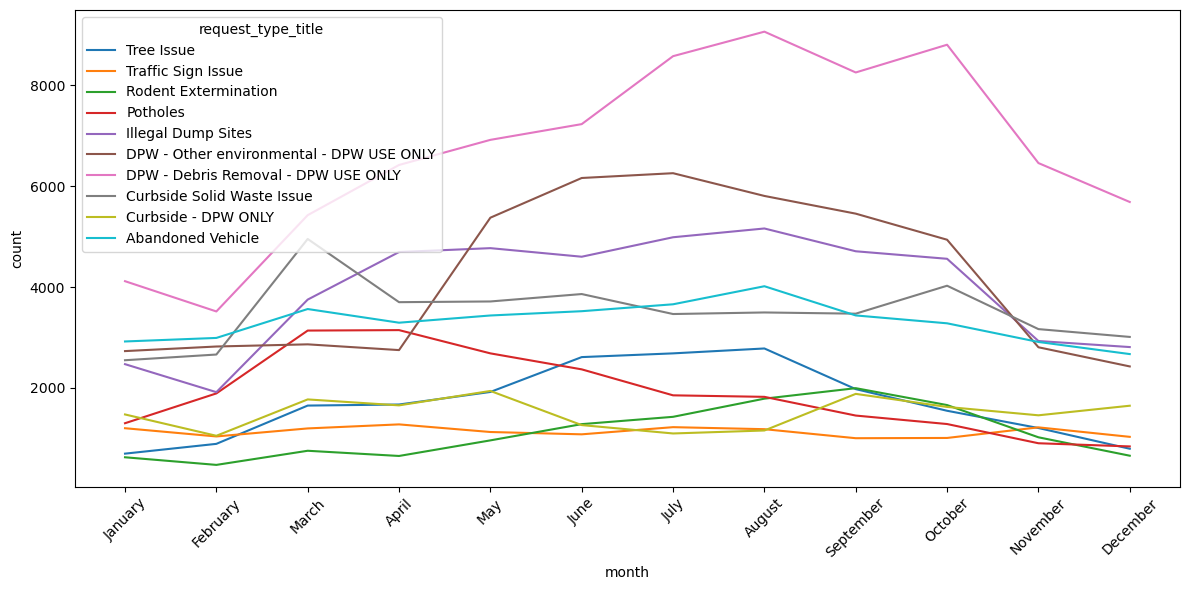

In [39]:
plt.figure(figsize=(12, 6))
detroit_top10_analysis = detroit_ip_top_10.copy()
detroit_top10_analysis['month'] = detroit_top10_analysis['created_at'].dt.month_name()

monthly_counts = detroit_top10_analysis.groupby(['month', 'request_type_title']).size().reset_index(name='count')
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                'August', 'September', 'October', 'November', 'December']
monthly_counts['month'] = pd.Categorical(monthly_counts['month'], categories=months_order, ordered=True)
monthly_counts = monthly_counts.sort_values('month')

sns.lineplot(data=monthly_counts, x='month', y='count', hue='request_type_title')

plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

#### 1.5.2 Requests Types by Number, Introduction Time, and Zip Codes

Observations:

1. Detroit began utilizing this platform in 2014 and kept adding or discontinuing categories within the system by two categories.
2. New types of requests were introduced, such as “dead animal removal.”
3. Subcategories of a request were implemented, possibly to enhance the workstreams. For instance, “Abandoned Vehicles” became “Abandoned Vehicles - On Street” and “Abandoned Vehicles - On Private Property.”
4. Some zip codes report significantly fewer issues than others. Further research reveals that one of the zip codes is assigned to the postal office (48243), and other zip codes are shared with neighboring cities (Hamtramck, Highland Park, Grosse Pointe).

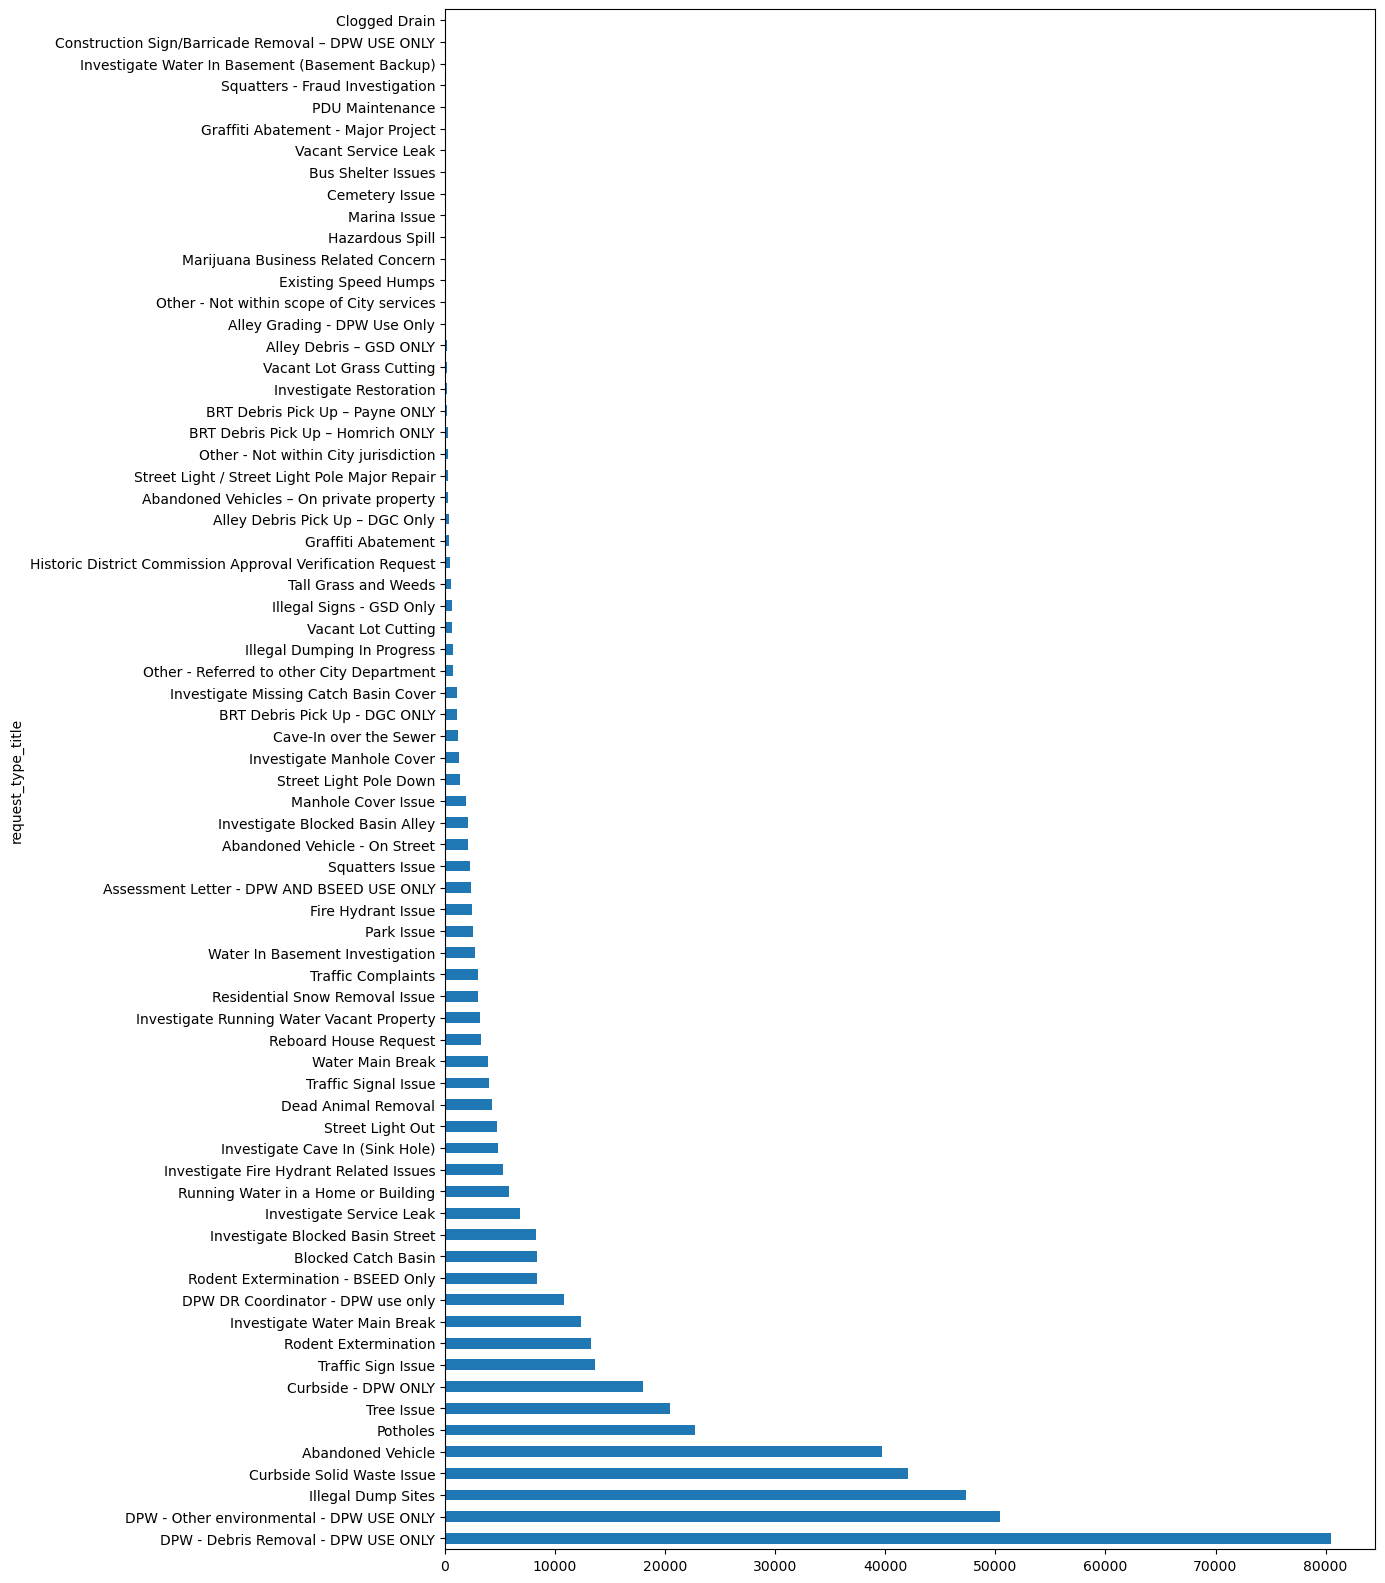

In [40]:
detroit_ip_cleaned.request_type_title.value_counts().plot(kind='barh', figsize=(12,20), )
plt.show()

Issues that are similar could potentially be grouped together; for instance, "Abandoned Vehicles" has three subcategories. It was noted that Detroit introduced new categories at a later stage.

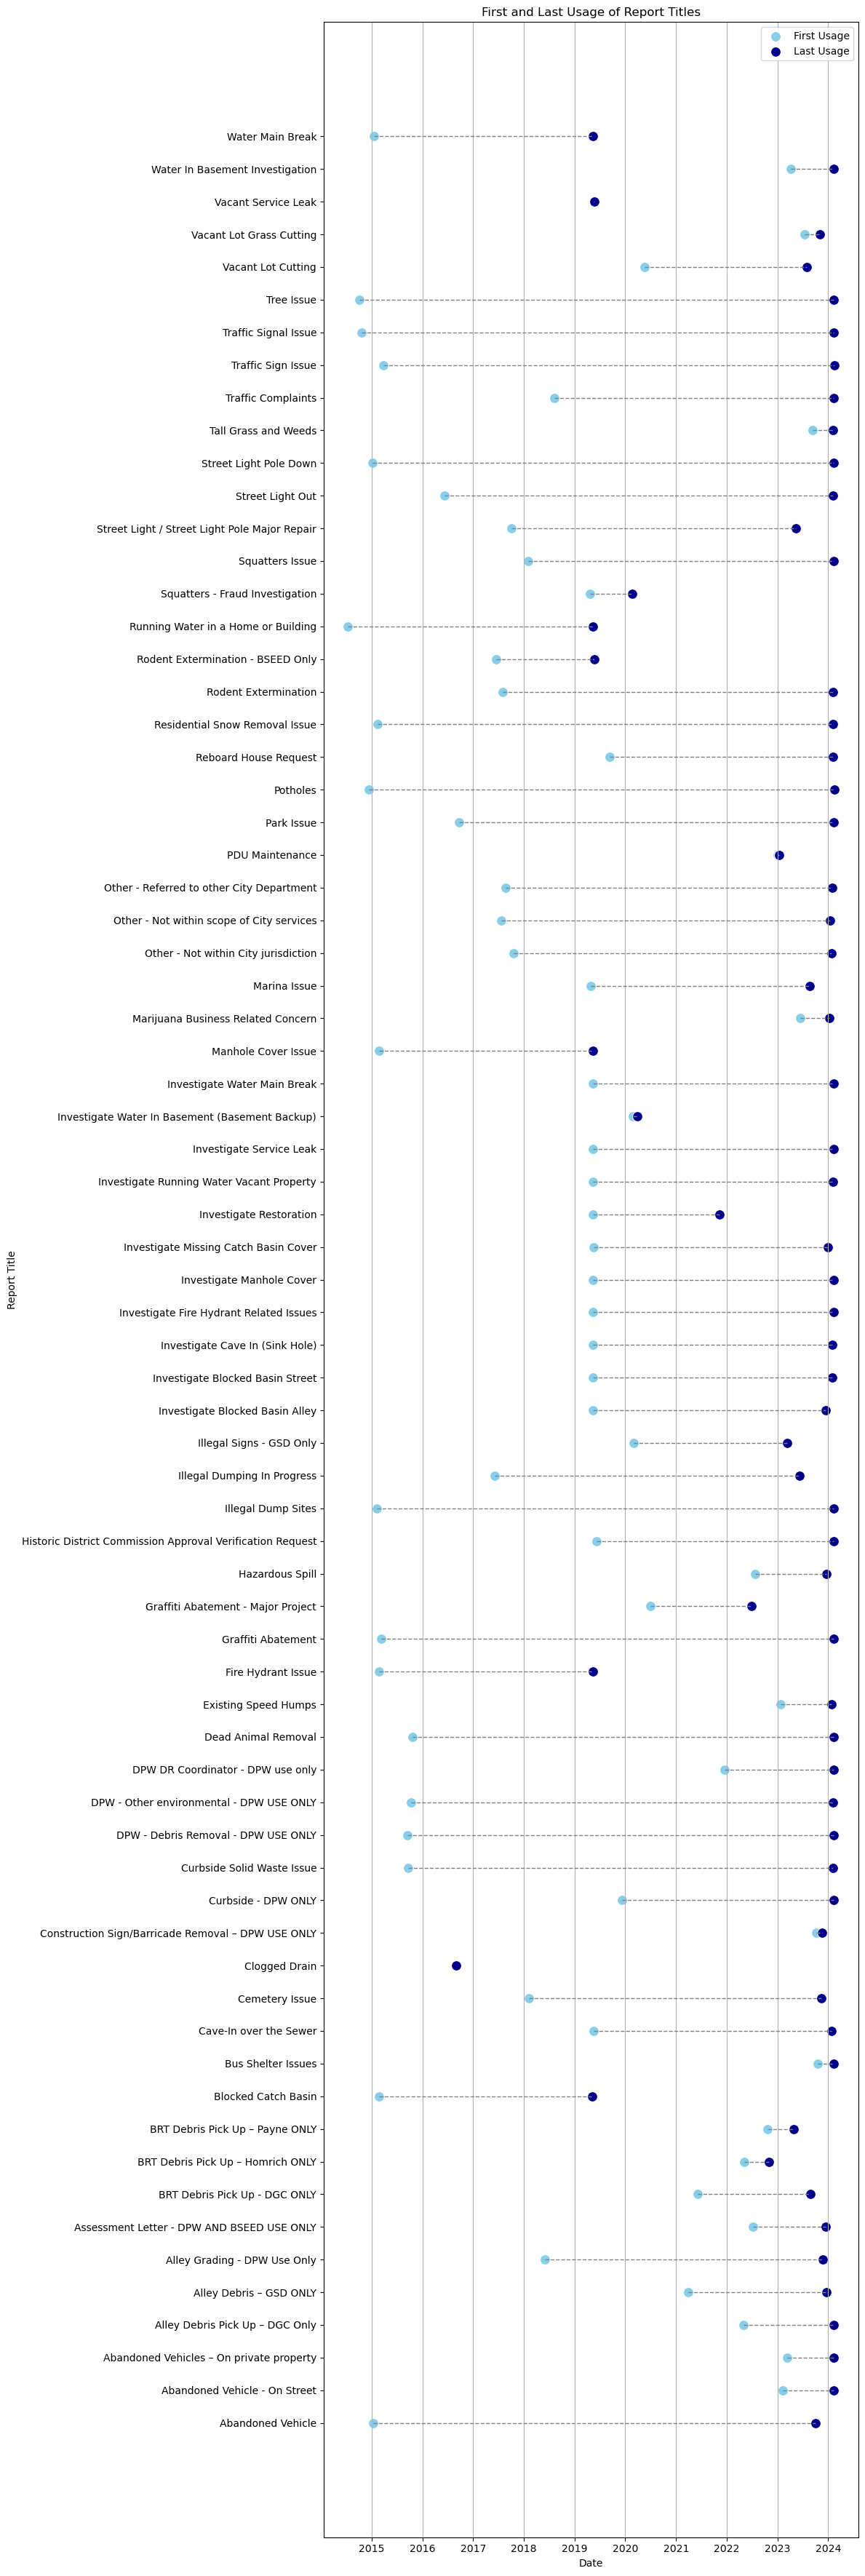

In [41]:
# Create a chart to understand when Detroit started to use a type of request (or stopped).
report_usage = detroit_ip_cleaned.groupby('request_type_title')['created_at'].agg([min, max]).reset_index()
report_usage.columns = ['request_type_title', 'first_usage', 'last_usage']
positions = range(len(report_usage))

plt.figure(figsize=(12, len(report_usage) / 2))  
ax = plt.gca()

# first usage dates.
sns.scatterplot(x='first_usage', y=positions, data=report_usage, color='skyblue', s=100, ax=ax, label='First Usage')

# last usage dates.
sns.scatterplot(x='last_usage', y=positions, data=report_usage, color='darkblue', s=100, ax=ax, label='Last Usage')

# Draw lines to connect the first and last usages.
for pos, (first, last) in enumerate(zip(report_usage['first_usage'], report_usage['last_usage'])):
    plt.plot([first, last], [pos, pos], 'gray', linestyle='--', lw=1)

ax.set_yticks(positions)
ax.set_yticklabels(report_usage['request_type_title'])

ax.set_xlabel('Date')
ax.set_ylabel('Report Title')
ax.set_title('First and Last Usage of Report Titles')
ax.xaxis.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


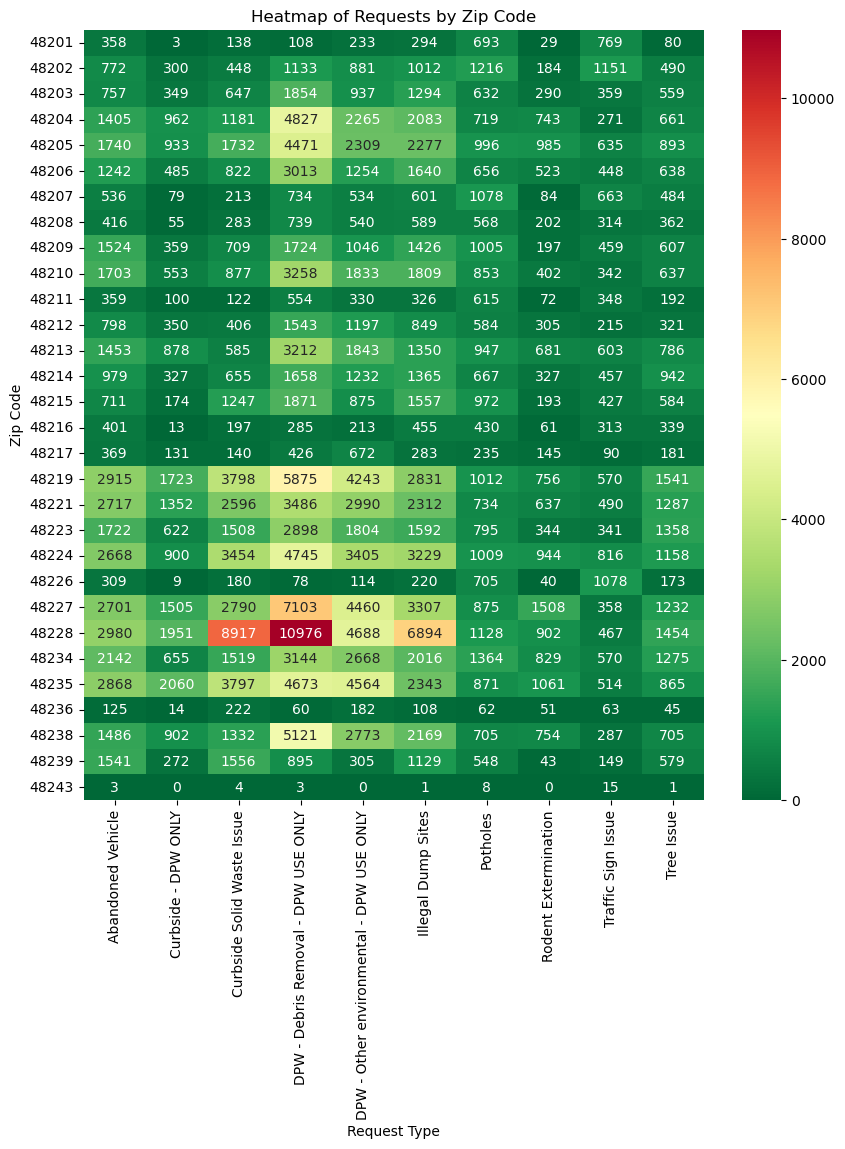

In [42]:
# Plot the top 10 issue counts in different zip codes.
detroit_311_common= detroit_ip_top_10.groupby(["zip_code", "request_type_title"]).id.count()
detroit_311_common = detroit_311_common.unstack().fillna(0)
detroit_311_common.reset_index(inplace=True)
detroit_311_common.set_index("zip_code", inplace=True)
plt.figure(figsize=(10, 10)) 
sns.heatmap(detroit_311_common, annot=True, cmap="RdYlGn_r", fmt='g')

plt.title('Heatmap of Requests by Zip Code')
plt.xlabel('Request Type')
plt.ylabel('Zip Code')

plt.show()

#### 1.5.3 Agency Only Categories

“Report_method” dropped

Categories labeled as “agency only,” like “DPW ONLY,” can only be utilized by city workers. They aren’t visible when submitting requests on the Improve Detroit website. However, city employees can also use request types that are publicly available. Not all reports made through city employees’ requests carry an “internal” tag. This means “report_method” isn’t a reliable indicator for separating requests made by city workers from the others.

In [43]:
detroit_ip_cleaned[detroit_ip_cleaned.request_type_title == "Curbside - DPW ONLY"].sample(20)
# All the incidents here seem to involve removing debris from the curbside.

,id,request_type_title,description,web_url,report_method,created_at,zip_code
213358,9488290,Curbside - DPW ONLY,blk bags and debris,https://seeclickfix.com/issues/9488290,direct,2021-03-09 13:48:33+00:00,48217
150318,11567428,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/11567428,direct,2021-12-01 15:09:13+00:00,48228
110796,12555114,Curbside - DPW ONLY,construction debris and blk bags at lot possib...,https://seeclickfix.com/issues/12555114,direct,2022-06-14 14:36:43+00:00,48208
205194,9748144,Curbside - DPW ONLY,construction debris,https://seeclickfix.com/issues/9748144,direct,2021-04-20 10:50:48+00:00,48213
210771,9529558,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/9529558,direct,2021-03-16 13:52:41+00:00,48219
105394,12844997,Curbside - DPW ONLY,construction debris at vacant house under reno...,https://seeclickfix.com/issues/12844997,direct,2022-07-14 13:45:27+00:00,48234
218531,9342891,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/9342891,direct,2021-02-11 09:32:51+00:00,48206
103454,12859266,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/12859266,direct,2022-07-18 09:37:51+00:00,48207
240543,8664597,Curbside - DPW ONLY,NaN,https://seeclickfix.com/issues/8664597,direct,2020-09-28 14:01:00+00:00,48235
237499,8745592,Curbside - DPW ONLY,boxes,https://seeclickfix.com/issues/8745592,direct,2020-10-12 11:58:05+00:00,48235


In [44]:
detroit_ip_cleaned[detroit_ip_cleaned.request_type_title == "DPW - Other environmental - DPW USE ONLY"].sample(20)
# Many issues could be better classified under other categories. They are not specific to trash/debris on the road.

,id,request_type_title,description,web_url,report_method,created_at,zip_code
441541,3231470,DPW - Other environmental - DPW USE ONLY,Rodent Extermination,https://seeclickfix.com/issues/3231470,phone,2017-02-24 15:59:04+00:00,48238
123376,12272373,DPW - Other environmental - DPW USE ONLY,BI-WEEKLY SPECIAL,https://seeclickfix.com/issues/12272373,internal,2022-05-03 08:56:31+00:00,48219
491526,2038394,DPW - Other environmental - DPW USE ONLY,Rodent Extermination,https://seeclickfix.com/issues/2038394,direct,2015-11-19 15:16:04+00:00,48209
295209,6912589,DPW - Other environmental - DPW USE ONLY,OMBUDSMAN 19-4114-C,https://seeclickfix.com/issues/6912589,internal,2019-10-31 17:43:54+00:00,48204
253091,8394119,DPW - Other environmental - DPW USE ONLY,OMBUDSMAN \n20-1515-C,https://seeclickfix.com/issues/8394119,other,2020-08-14 16:56:49+00:00,48224
390123,4170540,DPW - Other environmental - DPW USE ONLY,AREA SURVEY INSPECTION,https://seeclickfix.com/issues/4170540,other,2018-02-26 11:54:17+00:00,48219
343719,5363643,DPW - Other environmental - DPW USE ONLY,OMBUDSMAN 18-3642-C,https://seeclickfix.com/issues/5363643,other,2019-02-05 11:04:50+00:00,48227
439570,3280247,DPW - Other environmental - DPW USE ONLY,BAITING REQUESTED,https://seeclickfix.com/issues/3280247,phone,2017-03-20 13:08:16+00:00,48234
212945,9493614,DPW - Other environmental - DPW USE ONLY,AREA SURVEY INSPECTION,https://seeclickfix.com/issues/9493614,other,2021-03-10 08:31:45+00:00,48221
390380,4160532,DPW - Other environmental - DPW USE ONLY,AREA SURVEY,https://seeclickfix.com/issues/4160532,other,2018-02-23 15:53:27+00:00,48209


In [45]:
detroit_ip_cleaned[detroit_ip_cleaned.request_type_title == "DPW DR Coordinator - DPW use only"].sample(25)
# All the incidents here seem to involve removing debris from the curbside.

,id,request_type_title,description,web_url,report_method,created_at,zip_code
86667,13456827,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/13456827,direct,2022-09-22 08:56:03+00:00,48205
106560,12791917,DPW DR Coordinator - DPW use only,tree debris,https://seeclickfix.com/issues/12791917,direct,2022-07-05 08:18:33+00:00,48227
84815,13472276,DPW DR Coordinator - DPW use only,construction debris at vacant lot,https://seeclickfix.com/issues/13472276,direct,2022-09-26 09:56:09+00:00,48216
125784,12230673,DPW DR Coordinator - DPW use only,"bags, mattresses and misc",https://seeclickfix.com/issues/12230673,direct,2022-04-25 09:20:50+00:00,48227
123675,12285107,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/12285107,direct,2022-05-05 13:35:21+00:00,48206
31263,14997343,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/14997343,direct,2023-07-31 15:54:55+00:00,48208
104746,12807883,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/12807883,direct,2022-07-07 13:27:34+00:00,48227
75065,13772836,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/13772836,direct,2022-12-02 13:35:47+00:00,48224
105049,12827289,DPW DR Coordinator - DPW use only,NaN,https://seeclickfix.com/issues/12827289,direct,2022-07-11 15:53:53+00:00,48213
85062,13495434,DPW DR Coordinator - DPW use only,tree debris,https://seeclickfix.com/issues/13495434,direct,2022-09-30 10:40:04+00:00,48221


In [46]:
# Confirm these requests are also about debris by using unigram NLP to analyze the description section.
dpw_dr_data = detroit_ip_cleaned[detroit_ip_cleaned['request_type_title'] == "DPW DR Coordinator - DPW use only"]
all_dr_descriptions = ' '.join(dpw_dr_data['description'].dropna())

# Preprocessing
all_dr_descriptions_lower = all_dr_descriptions.lower()
all_descriptions_cleaned = re.sub(r'[^A-Za-z\s]', '', all_dr_descriptions_lower)
words = word_tokenize(all_descriptions_cleaned)
english_stopwords = set(stopwords.words('english'))
words_filtered = [word for word in words if word not in english_stopwords]
lemmatizer = WordNetLemmatizer()
words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
word_counts = Counter(words_lemmatized)

# Get the most common 100 words
most_common_words = word_counts.most_common(100)
print(most_common_words)

[('debris', 3510), ('misc', 2842), ('tree', 2302), ('vacant', 1982), ('lot', 1943), ('bag', 1553), ('wood', 1456), ('brush', 1083), ('construction', 1012), ('tire', 804), ('trash', 599), ('furniture', 372), ('box', 358), ('blk', 340), ('mattress', 289), ('sofa', 251), ('part', 165), ('car', 157), ('berm', 146), ('door', 112), ('drywall', 80), ('toilet', 78), ('chair', 78), ('fencing', 75), ('house', 75), ('side', 69), ('bumper', 67), ('carpet', 65), ('auto', 64), ('lawn', 64), ('cabinet', 61), ('dresser', 61), ('log', 61), ('front', 53), ('window', 40), ('pallet', 38), ('siding', 37), ('item', 36), ('bucket', 33), ('pile', 29), ('street', 28), ('shingle', 27), ('limb', 26), ('sink', 24), ('occ', 24), ('abandoned', 22), ('paneling', 22), ('tv', 21), ('across', 20), ('toy', 19), ('black', 19), ('courville', 18), ('container', 18), ('paint', 16), ('flooring', 16), ('multiple', 16), ('mixed', 15), ('park', 14), ('table', 13), ('clothing', 13), ('loader', 13), ('alley', 13), ('bulk', 12), (

In [47]:
# Most of the words relate to “debris” and “trash.” Some unexpected words are also related to waste, such as “shingle,” which referred to “roof shingle.” 
# This shows a downside of using unigram NLP processing.
shingle_entries = detroit_ip_cleaned[detroit_ip_cleaned['description'].str.contains("shingle", na=False, case=False)]
shingle_entries.head()

,id,request_type_title,description,web_url,report_method,created_at,zip_code
6586,15828685,DPW - Debris Removal - DPW USE ONLY,W Fisher Service Drive between Mullane and W F...,https://seeclickfix.com/issues/15828685,direct,2024-01-04 14:04:46+00:00,48209
7916,15801413,Abandoned Vehicles – On private property,This property has non-working vehicles in the ...,https://seeclickfix.com/issues/15801413,direct,2023-12-28 22:40:38+00:00,48235
8284,15739578,Curbside Solid Waste Issue,Has 4 Courvilles filled with roofing and garag...,https://seeclickfix.com/issues/15739578,direct,2023-12-13 11:09:40+00:00,48213
8722,15753011,Illegal Dump Sites,Contractors working on this building left garb...,https://seeclickfix.com/issues/15753011,direct,2023-12-16 10:38:12+00:00,48202
11463,15703317,Illegal Dump Sites,load of roofing shingles and other debris drop...,https://seeclickfix.com/issues/15703317,direct,2023-12-05 11:54:07+00:00,48204


In [48]:
# These requests are made by city workers. However, the “report_method” is not solely from “internal.”
# “report_method” doesn’t necessarily indicate that the report is coming from a worker.
detroit_ip_cleaned.drop(["report_method"], axis = 1, inplace = True)

### 1.6 Aggregating and Selecting Debris-related Categories

These categories have over 10,000 requests in total. I selected five of them for the next step.

| Issues                                   | Notes                                                                                                              |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| DPW - Debris Removal - DPW USE ONLY      | Selected                                                                                                           |
| DPW - Other environmental - DPW USE ONLY | Not selected. City workers use it for various issues. It is sometimes related to debris, but there's no guarantee. |
| Illegal Dump Sites                       | Selected                                                                                                           |
| Curbside Solid Waste Issue               | Selected                                                                                                           |
| Abandoned Vehicle                        | Not Selected. This is not a trash or debris-related issue.                                                         |
| Tree Issue                               | Not Selected. This is not a trash or debris-related issue.                                                         |
| Curbside - DPW ONLY                      | Selected                                                                                                           |
| Traffic Sign Issue                       | Not Selected. This is not a trash or debris-related issue.                                                         |
| Rodent Extermination                     | Not Selected. This is not a trash or debris-related issue.                                                         |
| Investigate Water Main Break             | Not Selected. This is not a trash or debris-related issue.                                                         |
| DPW DR Coordinator - DPW use only        | Selected. Closer examination shows city workers are using them for debris removal.                                 |


In [49]:
debris_variables = ["DPW - Debris Removal - DPW USE ONLY ", "Illegal Dump Sites", "Curbside Solid Waste Issue", "Curbside - DPW ONLY", "DPW DR Coordinator - DPW use only"]
detroit_ip_debris = detroit_ip_cleaned[detroit_ip_cleaned["request_type_title"].isin(debris_variables)]
detroit_ip_debris.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118302 entries, 411 to 511908
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   id                  118302 non-null  int64              
 1   request_type_title  118302 non-null  object             
 2   description         86374 non-null   object             
 3   web_url             118302 non-null  object             
 4   created_at          118302 non-null  datetime64[ns, UTC]
 5   zip_code            118302 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 6.3+ MB


In [50]:
# Now I will aggregate them to the zip_code level.
detroit_ip_debris = detroit_ip_debris.groupby("zip_code").id.count().reset_index()
detroit_ip_debris = detroit_ip_debris.rename(columns={"id":"count"})
detroit_ip_debris.zip_code = detroit_ip_debris.zip_code.astype("str")

## Section 2: Understand Neighborhood and SES Stats

In this section, I selected the zip codes that are fully located in Detroit and added new vacant property and Zillow housing index data.

In [51]:
detroit_ses = pd.read_csv("data/detroit_zip.csv")
detroit_ses.describe()

,zip,decommissioned,world_region,housing_count,irs_estimated_households,acs_estimated_households,population_count,irs_estimated_population,acs_estimated_population,white,...,pop_70_to_79,pop_80_plus,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_high_school_graduate,percent_bachelors_degree,percent_graduate_degree
count,40.000000,40.0,0.0,40.000000,37.000000,40.000000,40.000000,37.000000,40.00000,40.000000,...,40.000000,40.00000,37.000000,40.000000,40.000000,40.00000,40.000000,37.000000,37.000000,37.000000
mean,48216.025000,0.0,NaN,10416.500000,9991.891892,10821.650000,22249.650000,17505.945946,22379.57500,4919.975000,...,1332.900000,649.00000,28.469365,29194.725000,39965.050000,864.45000,97372.500000,83.978235,22.018824,8.983965
std,33.988299,0.0,NaN,5866.120174,5702.394155,6106.041349,14101.948124,10446.818351,14209.47768,6010.856676,...,926.098151,497.88316,11.459284,12606.931718,25044.655611,323.78926,88253.263142,9.369548,15.935380,8.089096
min,48021.000000,0.0,NaN,0.000000,1880.000000,0.000000,0.000000,2960.000000,0.00000,0.000000,...,0.000000,0.00000,3.781500,0.000000,0.000000,0.00000,0.000000,52.047200,6.489600,1.715500
25%,48209.750000,0.0,NaN,5667.500000,5740.000000,5950.000000,10204.500000,8270.000000,10233.25000,961.500000,...,747.000000,313.25000,21.564100,25082.500000,29983.000000,748.00000,43625.000000,80.503400,10.239400,3.986700
50%,48219.500000,0.0,NaN,10498.000000,8930.000000,11607.500000,21634.000000,16160.000000,21076.50000,2427.000000,...,1312.000000,545.50000,30.018000,27974.500000,33907.500000,860.50000,63100.000000,85.044600,18.127800,5.963200
75%,48230.750000,0.0,NaN,14203.750000,15580.000000,14653.000000,32095.500000,26960.000000,32179.50000,7418.500000,...,1804.000000,919.25000,37.191800,33176.000000,41543.250000,1026.25000,115275.000000,89.112300,25.759600,11.220400
max,48243.000000,0.0,NaN,22756.000000,20500.000000,22745.000000,53893.000000,39520.000000,57005.00000,25664.000000,...,3577.000000,2003.00000,45.781800,63379.000000,125018.000000,1610.00000,368300.000000,98.441300,70.762900,34.602100


In [52]:
detroit_ses.dtypes

zip                                             int64
type                                           object
decommissioned                                  int64
primary_city                                   object
acceptable_cities                              object
unacceptable_cities                            object
state                                          object
county                                         object
timezone                                       object
area_codes                                     object
world_region                                  float64
housing_count                                   int64
irs_estimated_households                      float64
acs_estimated_households                        int64
population_count                                int64
irs_estimated_population                      float64
acs_estimated_population                        int64
white                                           int64
black_or_african_american   

In [53]:
detroit_ses.columns

Index(['zip', 'type', 'decommissioned', 'primary_city', 'acceptable_cities',
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'housing_count', 'irs_estimated_households',
       'acs_estimated_households', 'population_count',
       'irs_estimated_population', 'acs_estimated_population', 'white',
       'black_or_african_american', 'american_indian_or_alaskan_native',
       'asian', 'native_hawaiian_and_other_pacific_islander', 'other_race',
       'two_or_more_races', 'hispanic_or_latino', 'total_male_population',
       'total_female_population', 'pop_under_10', 'pop_10_to_19',
       'pop_20_to_29', 'pop_30_to_39', 'pop_40_to_49', 'pop_50_to_59',
       'pop_60_to_69', 'pop_70_to_79', 'pop_80_plus',
       'percent_population_in_poverty', 'median_earnings_past_year',
       'median_household_income', 'median_gross_rent', 'median_home_value',
       'percent_high_school_graduate', 'percent_bachelors_degree',
       'percent_graduate_d

In [54]:
# Focus on Education Level, Income Level, and Property Value
detroit_ses_new = detroit_ses.drop(['percent_high_school_graduate', "type", "decommissioned","state", "county", "timezone", "area_codes", "world_region", "irs_estimated_households", "irs_estimated_population", "pop_10_to_19", "pop_20_to_29", "pop_30_to_39", "pop_40_to_49", "pop_50_to_59", "pop_60_to_69", "pop_70_to_79", "pop_80_plus", "unacceptable_cities", "acs_estimated_households","acs_estimated_population", "pop_under_10", "american_indian_or_alaskan_native", "asian", "native_hawaiian_and_other_pacific_islander", "other_race", "two_or_more_races", "housing_count", "white", "black_or_african_american", "hispanic_or_latino", "total_female_population", "total_male_population"], axis=1)

In [55]:
len(detroit_ip_debris.zip_code.unique())
# We are Interested in Analyzing 30 Zip Codes Reported

30

### 2.1 Selecting Detroit Zip Codes
Some zip codes are not only used by Detroit but also adjacent cities . However, the social economic status are collected based on the zip codes. To compare neighborhood that are similar to each other. I will select zip codes that are fully located in Detroit.

In [56]:
detroit_ses_new

,zip,primary_city,acceptable_cities,population_count,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_bachelors_degree,percent_graduate_degree
0,48201,Detroit,NaN,14500,44.5978,28000,21180,667,343000,34.5247,15.2985
1,48202,Detroit,NaN,17260,31.8474,26509,31269,762,164900,32.9281,12.8517
2,48204,Detroit,NaN,21738,37.8955,24152,27609,861,41700,9.6783,5.0889
3,48205,Detroit,NaN,34056,24.8744,28703,39988,1042,34800,6.4896,1.8805
4,48206,Detroit,NaN,15712,32.7013,30339,32200,762,60800,20.3896,11.2204
5,48207,Detroit,NaN,21704,29.0157,36369,37139,949,142700,33.3050,16.7898
6,48208,Detroit,NaN,8090,40.5287,31321,23827,712,132300,22.2958,5.9632
7,48209,Detroit,NaN,27096,36.2620,25289,34104,758,56500,8.1357,2.7119
8,48210,Detroit,NaN,27155,36.8735,23506,33711,826,44100,7.0763,1.7155
9,48211,Detroit,Hamtramck,5447,44.9501,20923,30271,840,41700,14.2857,3.2727


In [57]:
detroit_ses_new = detroit_ses_new.rename(columns={'zip':'zip_code'})

In [58]:
detroit_ses_new.zip_code = detroit_ses_new.zip_code.astype("str")

In [59]:
len(detroit_ses_new[detroit_ses_new.acceptable_cities.notnull()])

15

In [60]:
# Remove the 15 Zip Codes That Are Not Fully in Detroit
detroit_ses_new = detroit_ses_new[~detroit_ses_new.acceptable_cities.notnull()]
detroit_ses_new.drop(["acceptable_cities", "primary_city"], axis = 1, inplace = True)

In [61]:
# Intersect with Improve Detroit Data to obtain zip codes that are both fully located in Detroit 
# and was used for reporting
detroit_ses_new = detroit_ses_new[detroit_ses_new.zip_code.isin(detroit_ip_cleaned.zip_code.unique())]

In [62]:
len(detroit_ses_new)
# These 23 zip codes are in Detroit

23

In [63]:
detroit_ses_new

,zip_code,population_count,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_bachelors_degree,percent_graduate_degree
0,48201,14500,44.5978,28000,21180,667,343000,34.5247,15.2985
1,48202,17260,31.8474,26509,31269,762,164900,32.9281,12.8517
2,48204,21738,37.8955,24152,27609,861,41700,9.6783,5.0889
3,48205,34056,24.8744,28703,39988,1042,34800,6.4896,1.8805
4,48206,15712,32.7013,30339,32200,762,60800,20.3896,11.2204
5,48207,21704,29.0157,36369,37139,949,142700,33.3050,16.7898
6,48208,8090,40.5287,31321,23827,712,132300,22.2958,5.9632
7,48209,27096,36.2620,25289,34104,758,56500,8.1357,2.7119
8,48210,27155,36.8735,23506,33711,826,44100,7.0763,1.7155
10,48213,19088,36.7138,20533,28718,718,39500,8.2845,2.5857


In [64]:
detroit_ses_new[detroit_ses_new.isna().any(axis=1)]
# 48243 is a tiny part of Detroit, encompassing only 0.02 square miles, and is occupied by the Renaissance Center. According to the Census Bureau, this area is a business building with no residential population. R

,zip_code,population_count,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_bachelors_degree,percent_graduate_degree
27,48243,0,NaN,0,0,0,0,NaN,NaN


In [65]:
# Remove 48243
detroit_ses_new.dropna(how="any", inplace = True)

This is the final map I created using Tableau to depict all Detroit neighborhoods included in this dataset.

<table>
  <tr>
    <td><img src="viz/neighborhood.png" alt="pop_zip" /></td>
  </tr>
</table>  

### 2.2 Adding Vacant Properties Data and Zillow Home Value Index 

#### 2.2.1 Adding Vacant Properties Data
This dataset contains all new vacant property registrations from 2019/01/03 to 2024/02/21 in the City of Detroit. I retrieved their zip codes using the Google Geocoding API. See the vacant_helper Jupyter notebook for information.

In [66]:
vacant_with_zip = pd.read_csv("data/vacant_with_zip.csv")

In [67]:
# Aggregate 
vacant_with_zip_stats = vacant_with_zip.groupby("zip_code").X.count().reset_index()
vacant_with_zip_stats.zip_code = vacant_with_zip_stats.zip_code.astype("int")
vacant_with_zip_stats.zip_code = vacant_with_zip_stats.zip_code.astype("str")
vacant_with_zip_stats = vacant_with_zip_stats[vacant_with_zip_stats.zip_code.isin(detroit_ses_new.zip_code)].reset_index()
vacant_with_zip_stats = vacant_with_zip_stats.rename(columns={'X':"new_vacant_properties"})
detroit_ses_new = detroit_ses_new.merge(vacant_with_zip_stats, how="left",left_on="zip_code", right_on="zip_code")

#### 2.2.2 Adding Zillow Home Value Index 

In [68]:
zillow_index = pd.read_csv("data/zillow_housing_index.csv")
zillow_index.describe()

,RegionID,SizeRank,RegionName,1/31/00,2/29/00,3/31/00,4/30/00,5/31/00,6/30/00,7/31/00,...,4/30/23,5/31/23,6/30/23,7/31/23,8/31/23,9/30/23,10/31/23,11/30/23,12/31/23,1/31/24
count,26353.000000,26353.000000,26353.000000,1.289500e+04,1.296100e+04,1.297500e+04,1.299400e+04,1.305700e+04,1.306800e+04,1.308400e+04,...,2.588500e+04,2.588500e+04,2.588600e+04,2.588700e+04,2.588700e+04,2.588700e+04,2.597600e+04,2.609900e+04,2.623600e+04,2.635300e+04
mean,80487.632490,13781.332676,48309.554055,1.405206e+05,1.406426e+05,1.409695e+05,1.418030e+05,1.426953e+05,1.437203e+05,1.448511e+05,...,3.219967e+05,3.238969e+05,3.260960e+05,3.281059e+05,3.299271e+05,3.314354e+05,3.320309e+05,3.322788e+05,3.318629e+05,3.313069e+05
std,28298.094172,8399.037910,27381.741028,1.004680e+05,1.008069e+05,1.013529e+05,1.025630e+05,1.037899e+05,1.053116e+05,1.069085e+05,...,2.901440e+05,2.907637e+05,2.926484e+05,2.951760e+05,2.978208e+05,3.002064e+05,3.016971e+05,3.025110e+05,3.027300e+05,3.022722e+05
min,58196.000000,1.000000,1001.000000,2.842523e+03,2.841210e+03,2.835958e+03,2.830253e+03,2.818620e+03,2.811822e+03,2.826646e+03,...,2.440300e+04,2.497348e+04,2.527708e+04,2.539065e+04,2.545900e+04,2.505543e+04,2.445636e+04,2.418387e+04,2.479384e+04,2.511877e+04
25%,68864.000000,6666.000000,25978.000000,7.944324e+04,7.939839e+04,7.950771e+04,7.975076e+04,8.012169e+04,8.048950e+04,8.080268e+04,...,1.627840e+05,1.640851e+05,1.653078e+05,1.662180e+05,1.667257e+05,1.671063e+05,1.672776e+05,1.672711e+05,1.668259e+05,1.660658e+05
50%,78827.000000,13367.000000,47832.000000,1.163710e+05,1.163550e+05,1.165001e+05,1.168703e+05,1.172594e+05,1.178657e+05,1.185567e+05,...,2.463282e+05,2.483317e+05,2.502192e+05,2.515559e+05,2.528939e+05,2.538902e+05,2.540625e+05,2.544400e+05,2.540012e+05,2.536053e+05
75%,88635.000000,20354.000000,70358.000000,1.707890e+05,1.707477e+05,1.710912e+05,1.719291e+05,1.727481e+05,1.735760e+05,1.747926e+05,...,3.826178e+05,3.847559e+05,3.871796e+05,3.890845e+05,3.914085e+05,3.930970e+05,3.936189e+05,3.938182e+05,3.931719e+05,3.929619e+05
max,808739.000000,39992.000000,99929.000000,1.955453e+06,1.971933e+06,1.995827e+06,2.046388e+06,2.108480e+06,2.178939e+06,2.249665e+06,...,7.478518e+06,7.479609e+06,7.478438e+06,7.503025e+06,7.531593e+06,7.552881e+06,7.552465e+06,7.530965e+06,7.482086e+06,7.400900e+06


In [69]:
# RegionName is zip code
zillow_index["RegionName"] = zillow_index["RegionName"].astype("str")
zillow_index = zillow_index.rename(columns={"RegionName":"zip_code"})
zillow_index = zillow_index[zillow_index.zip_code.isin(detroit_ses_new.zip_code)].reset_index()

# Use the most updated index
zillow_index_new = zillow_index[["zip_code", "1/31/24"]]
zillow_index_new = zillow_index_new.rename(columns={"1/31/24":"2024_zhvi"})
detroit_ses_new = detroit_ses_new.merge(zillow_index_new, how="left",left_on="zip_code", right_on="zip_code")

In [70]:
detroit_ses_new.drop("index", axis = 1, inplace = True)

In [71]:
detroit_ses_new

,zip_code,population_count,percent_population_in_poverty,median_earnings_past_year,median_household_income,median_gross_rent,median_home_value,percent_bachelors_degree,percent_graduate_degree,new_vacant_properties,2024_zhvi
0,48201,14500,44.5978,28000,21180,667,343000,34.5247,15.2985,10,429363.101108
1,48202,17260,31.8474,26509,31269,762,164900,32.9281,12.8517,49,182322.783755
2,48204,21738,37.8955,24152,27609,861,41700,9.6783,5.0889,167,52158.185130
3,48205,34056,24.8744,28703,39988,1042,34800,6.4896,1.8805,180,50861.606303
4,48206,15712,32.7013,30339,32200,762,60800,20.3896,11.2204,106,83890.135447
5,48207,21704,29.0157,36369,37139,949,142700,33.3050,16.7898,65,161877.575907
6,48208,8090,40.5287,31321,23827,712,132300,22.2958,5.9632,60,116433.096325
7,48209,27096,36.2620,25289,34104,758,56500,8.1357,2.7119,59,80569.197166
8,48210,27155,36.8735,23506,33711,826,44100,7.0763,1.7155,71,62182.203095
9,48213,19088,36.7138,20533,28718,718,39500,8.2845,2.5857,96,47240.981561


### 2.3 Visualize the Neighborhood

I found that 48227 and 48201 appear very different from other neighborhoods. These are Detroit’s downtown and midtown. Their urban environment can affect the volume of debris-related environment.

Other Observations:

1. Zip Code 48226, Downtown Detroit, is an outlier compared to other neighborhoods. It has the highest income and the highest education level.
2. Midtown (48201) is very similar to the rest of the zip codes, except for the median home value.
3. There are new vacant properties in all zip codes. Downtown (48226) and Midtown (48201) are notable outliers in this regard. Most areas in 48217 are not residential, which could explain why there are fewer new vacant properties there.

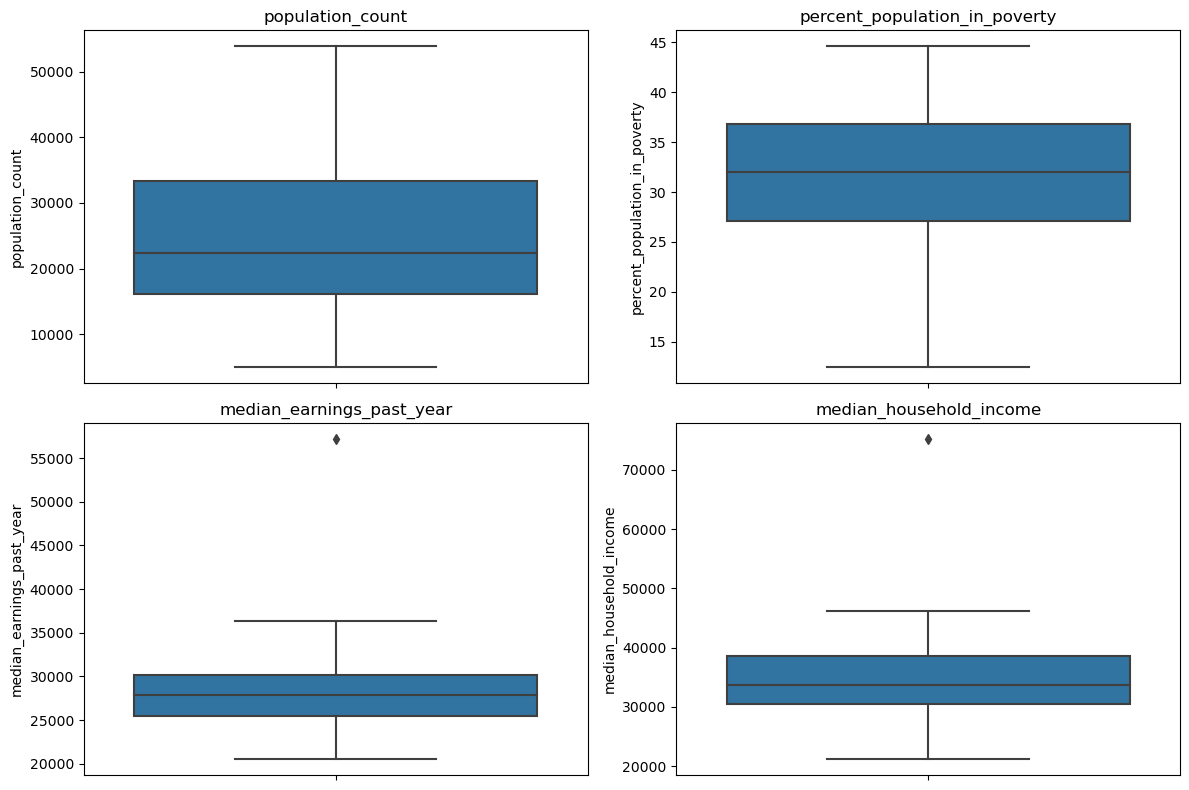

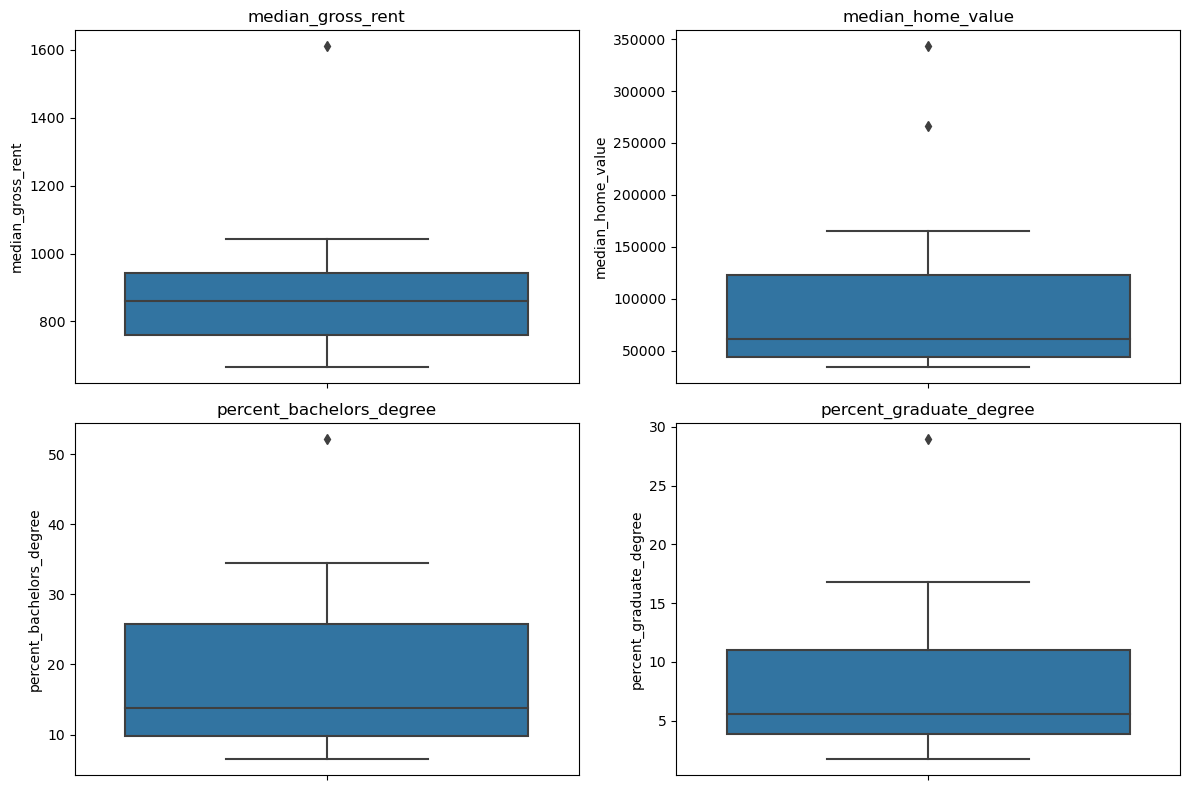

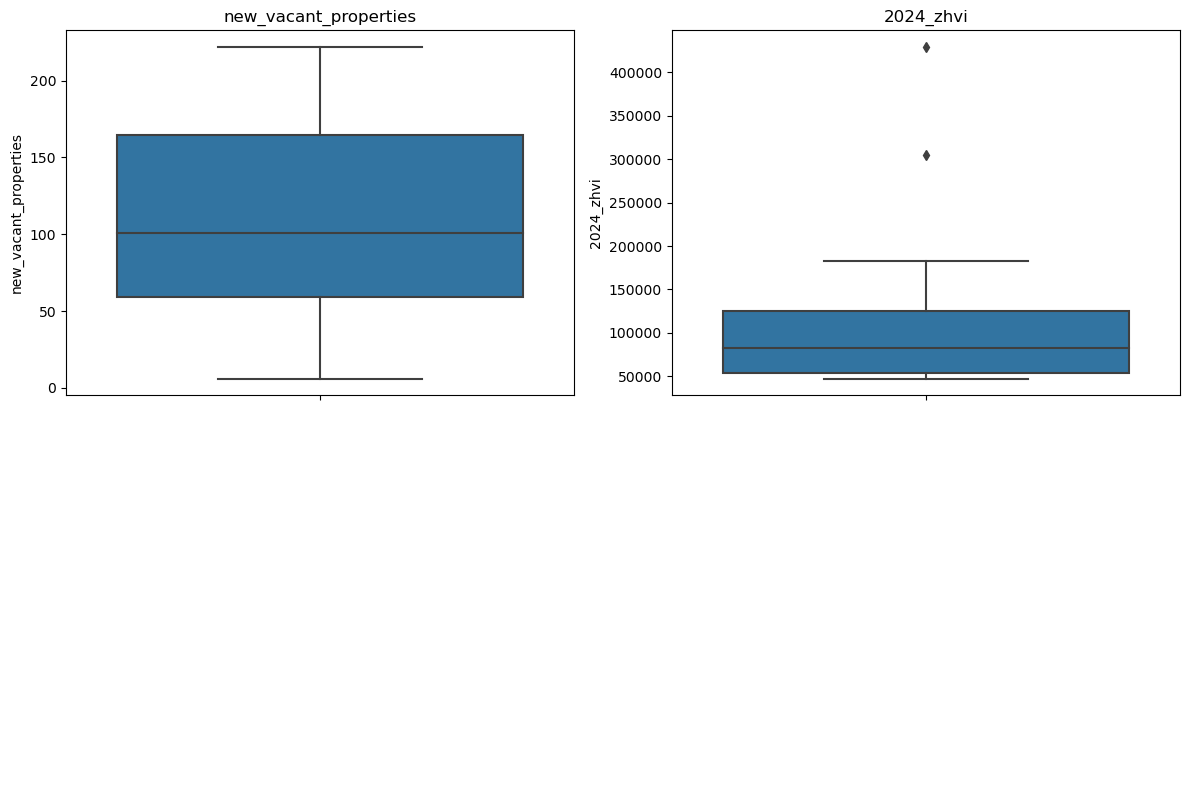

In [72]:
# Boxplot to check for outliers
# There are a few outliers from these two zip codes. I will address them later.
num_columns = len(detroit_ses_new.columns) - 1 
num_figures = (num_columns + 3) // 4  
for fig_index in range(num_figures):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 
    axs = axs.ravel() #
    
    for i in range(4):
        column_index = 4 * fig_index + i
        if column_index >= num_columns:
            axs[i].axis('off') 
            continue
        
        column = detroit_ses_new.columns[column_index + 1]
        sns.boxplot(y=detroit_ses_new[column], ax=axs[i]) 
        axs[i].set_title(column) 

    plt.tight_layout() 
    plt.show() 

/var/folders/52/f14n90tn2yg2972wb_xq6pfm0000gn/T/ipykernel_9664/2022882656.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(detroit_ses_new['zip_code'], rotation=90, ha='right')


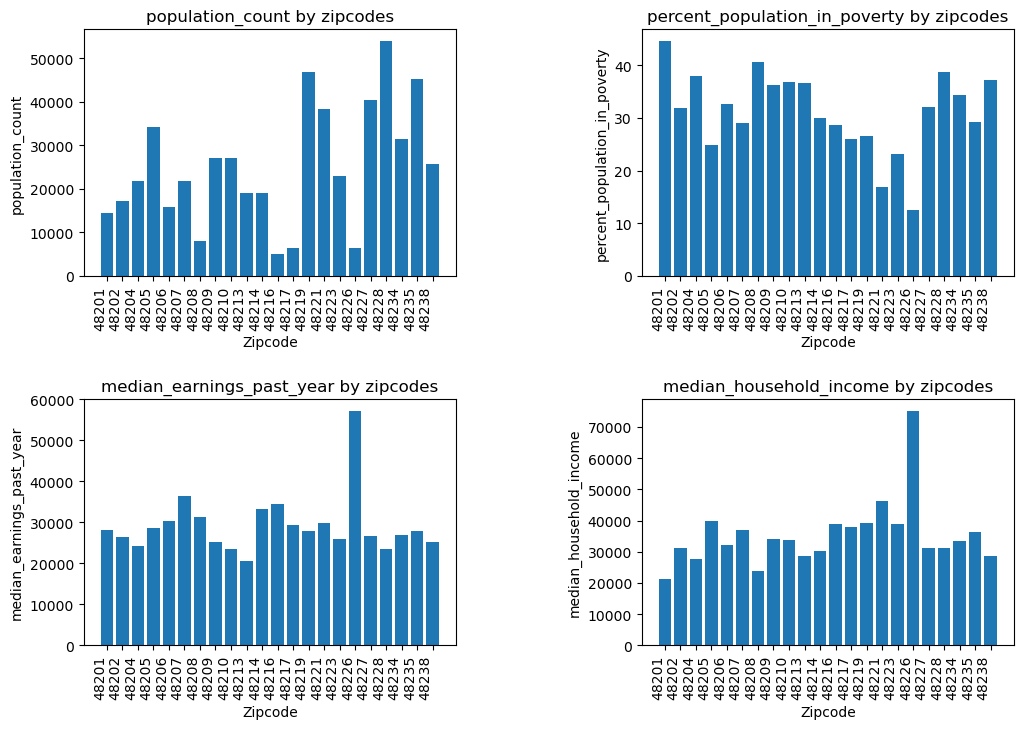

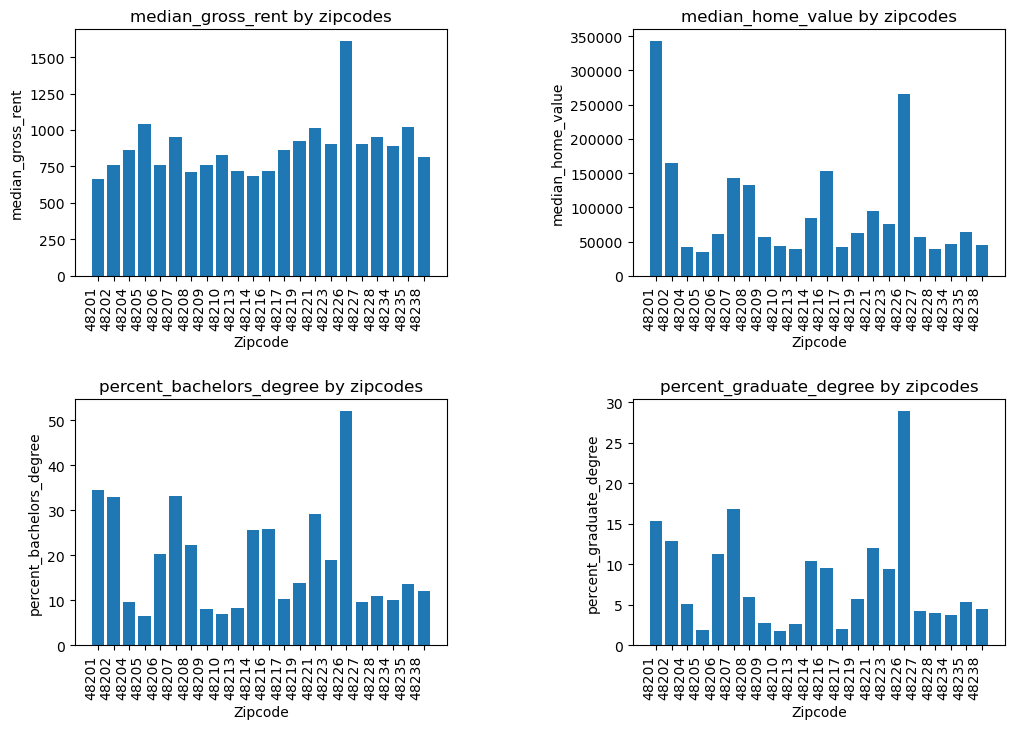

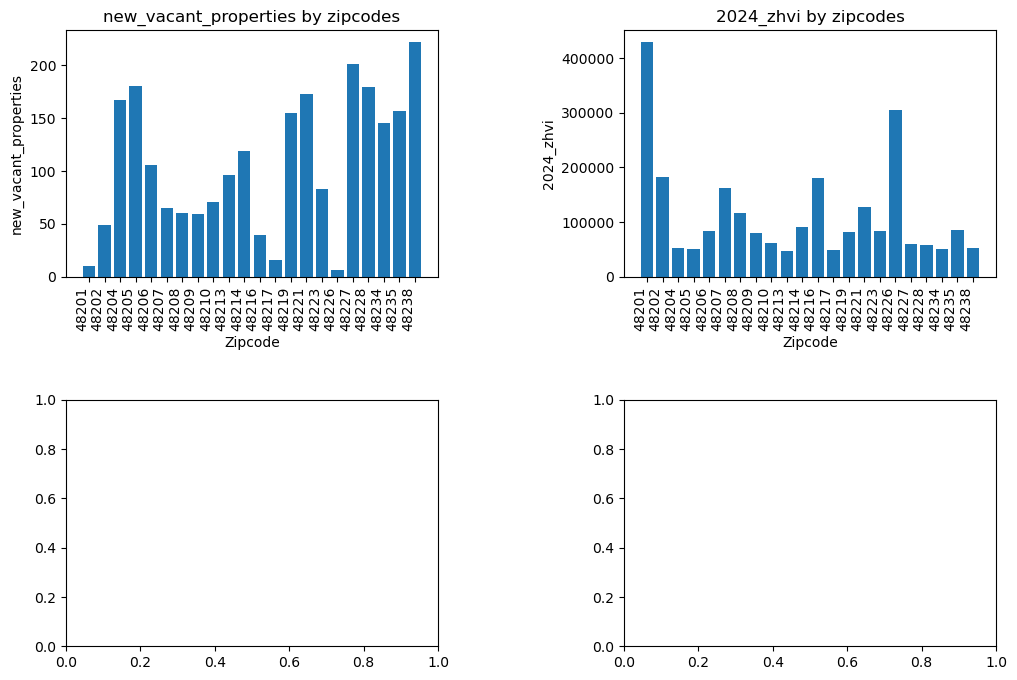

In [73]:
# Bar chart
for fig_index in range(num_figures):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  
    axs = axs.flatten()  
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  

    for i in range(4):
        column_index = 4 * fig_index + i
        if column_index >= num_columns:
            break  
        column = detroit_ses_new.columns[column_index + 1] 
        
        
        axs[i].bar(detroit_ses_new['zip_code'], detroit_ses_new[column])
        axs[i].set_title(f'{column} by zipcodes')
        axs[i].set_xlabel('Zipcode')
        axs[i].set_xticklabels(detroit_ses_new['zip_code'], rotation=90, ha='right')
        axs[i].set_ylabel(column)

    plt.show()

Visualizations from Tableau to better understand their relevance to the neighborhood

<table>
  <tr>
    <td><img src="viz/pop_zip.png" alt="pop_zip" /></td>
    <td><img src="viz/ppp_zip.png" alt="ppp_zip" /></td>
  </tr>
  <tr>
    <td><img src="viz/mgr_zip.png" alt="mgr_zip" /></td>
    <td><img src="viz/mhv_zip.png" alt="mhv_zip" /></td>
  </tr>
<tr>
    <td><img src="viz/pbd_zip.png" alt="mgr_zip" /></td>
    <td><img src="viz/pgd_zip.png" alt="mhv_zip" /></td>
  </tr>
    <tr>
    <td><img src="viz/nvp_zip.png" alt="mgr_zip" /></td>
    <td><img src="viz/zvhi_zip.png" alt="mhv_zip" /></td>
  </tr>
</table>

## Section 3: Analysis of Improve Detroit Requests and SES Stats

In this section, I studied how each variable is related to the requests per resident in different neighborhoods. The findings can be found in the executive summary.

In [74]:
detroit_ip_debris_ses = detroit_ses_new.merge(detroit_ip_debris, left_on = "zip_code", right_on = "zip_code")

In [75]:
# Normalize requests with population to per resident for comparability
detroit_ip_debris_ses["request_per_resident"] = detroit_ip_debris_ses["count"]/detroit_ip_debris_ses["population_count"]
detroit_ip_debris_ses.set_index("zip_code", inplace=True)

### 3.1 1. Zip Codes with higher Home Values Have Fewer Issues?

I used OLS regression as this method is most interpretable and easy to understand.

/Users/andrewye/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

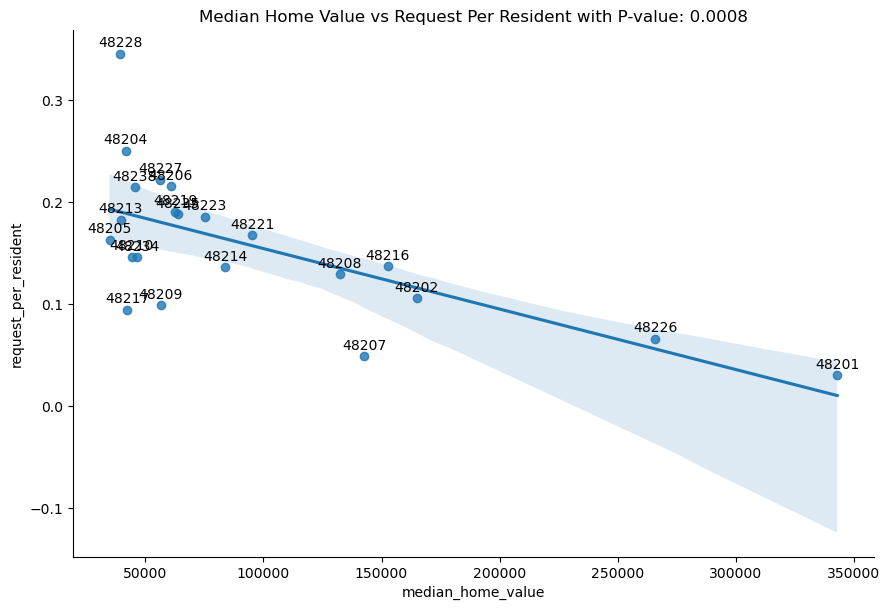

In [76]:
X = sm.add_constant(detroit_ip_debris_ses['median_home_value']) 
Y = detroit_ip_debris_ses["request_per_resident"]
model_1 = sm.OLS(Y, X).fit()
p_value = model_1.pvalues["median_home_value"]

plt.figure(figsize=(10, 6))  
sns.lmplot(x='median_home_value', y='request_per_resident', data=detroit_ip_debris_ses, aspect=1.5, height=6)

# Annotating each data point with its ZIP code
for index, row in detroit_ip_debris_ses.iterrows():
    plt.annotate(index, (row['median_home_value'], row['request_per_resident']), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title(f'Median Home Value vs Request Per Resident with P-value: {p_value:.4f}') 
plt.show()


The statistical analysis yielded a p-value of 0.0008, indicating a statistically significant association between the median home value and the frequency of incidents reported on the Improve Detroit platform.

Downtown Detroit (48226) and Midtown Detroit (48201) have very high home values and fewer incidents. For a better analysis, let's remove these two outliers

In [77]:
detroit_ip_debris_ses = detroit_ip_debris_ses.drop(index=['48201', '48226'])

/Users/andrewye/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

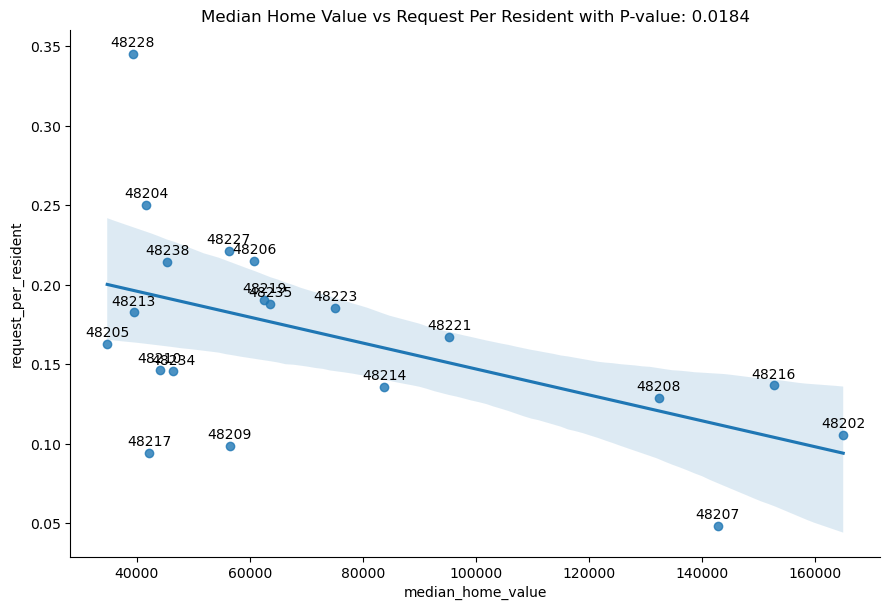

In [78]:
X = sm.add_constant(detroit_ip_debris_ses['median_home_value']) 
Y = detroit_ip_debris_ses["request_per_resident"]
model_1 = sm.OLS(Y, X).fit()
p_value = model_1.pvalues["median_home_value"]

plt.figure(figsize=(10, 6))  
sns.lmplot(x='median_home_value', y='request_per_resident', data=detroit_ip_debris_ses, aspect=1.5, height=6)

# Annotating each data point with its ZIP code
for index, row in detroit_ip_debris_ses.iterrows():
    plt.annotate(index, (row['median_home_value'], row['request_per_resident']), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title(f'Median Home Value vs Request Per Resident with P-value: {p_value:.4f}') 
plt.show()


The statistical analysis yielded a p-value of 0.0184, still indicating a statistically significant association between the median home value and the frequency of incidents reported on the Improve Detroit platform in suburban areas.

### 3.2 Other Social Economic Status 

I identified three other variables that are strongly associated with few reports per resident. These are median_earnings_past_year, 2024_zhvi, and new_vacant_properties.

percent_population_in_poverty: p-vaule 0.2687 adj. R²: 0.0157
median_earnings_past_year: p-vaule 0.0167 adj. R²: 0.2386
median_household_income: p-vaule 0.3375 adj. R²: -0.0015
median_gross_rent: p-vaule 0.3108 adj. R²: 0.0046
median_home_value: p-vaule 0.0184 adj. R²: 0.2315
2024_zhvi: p-vaule 0.0289 adj. R²: 0.1961
new_vacant_properties: p-vaule 0.0008 adj. R²: 0.4443
percent_bachelors_degree: p-vaule 0.0677 adj. R²: 0.1277
percent_graduate_degree: p-vaule 0.1809 adj. R²: 0.0470


/var/folders/52/f14n90tn2yg2972wb_xq6pfm0000gn/T/ipykernel_9664/3462907978.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


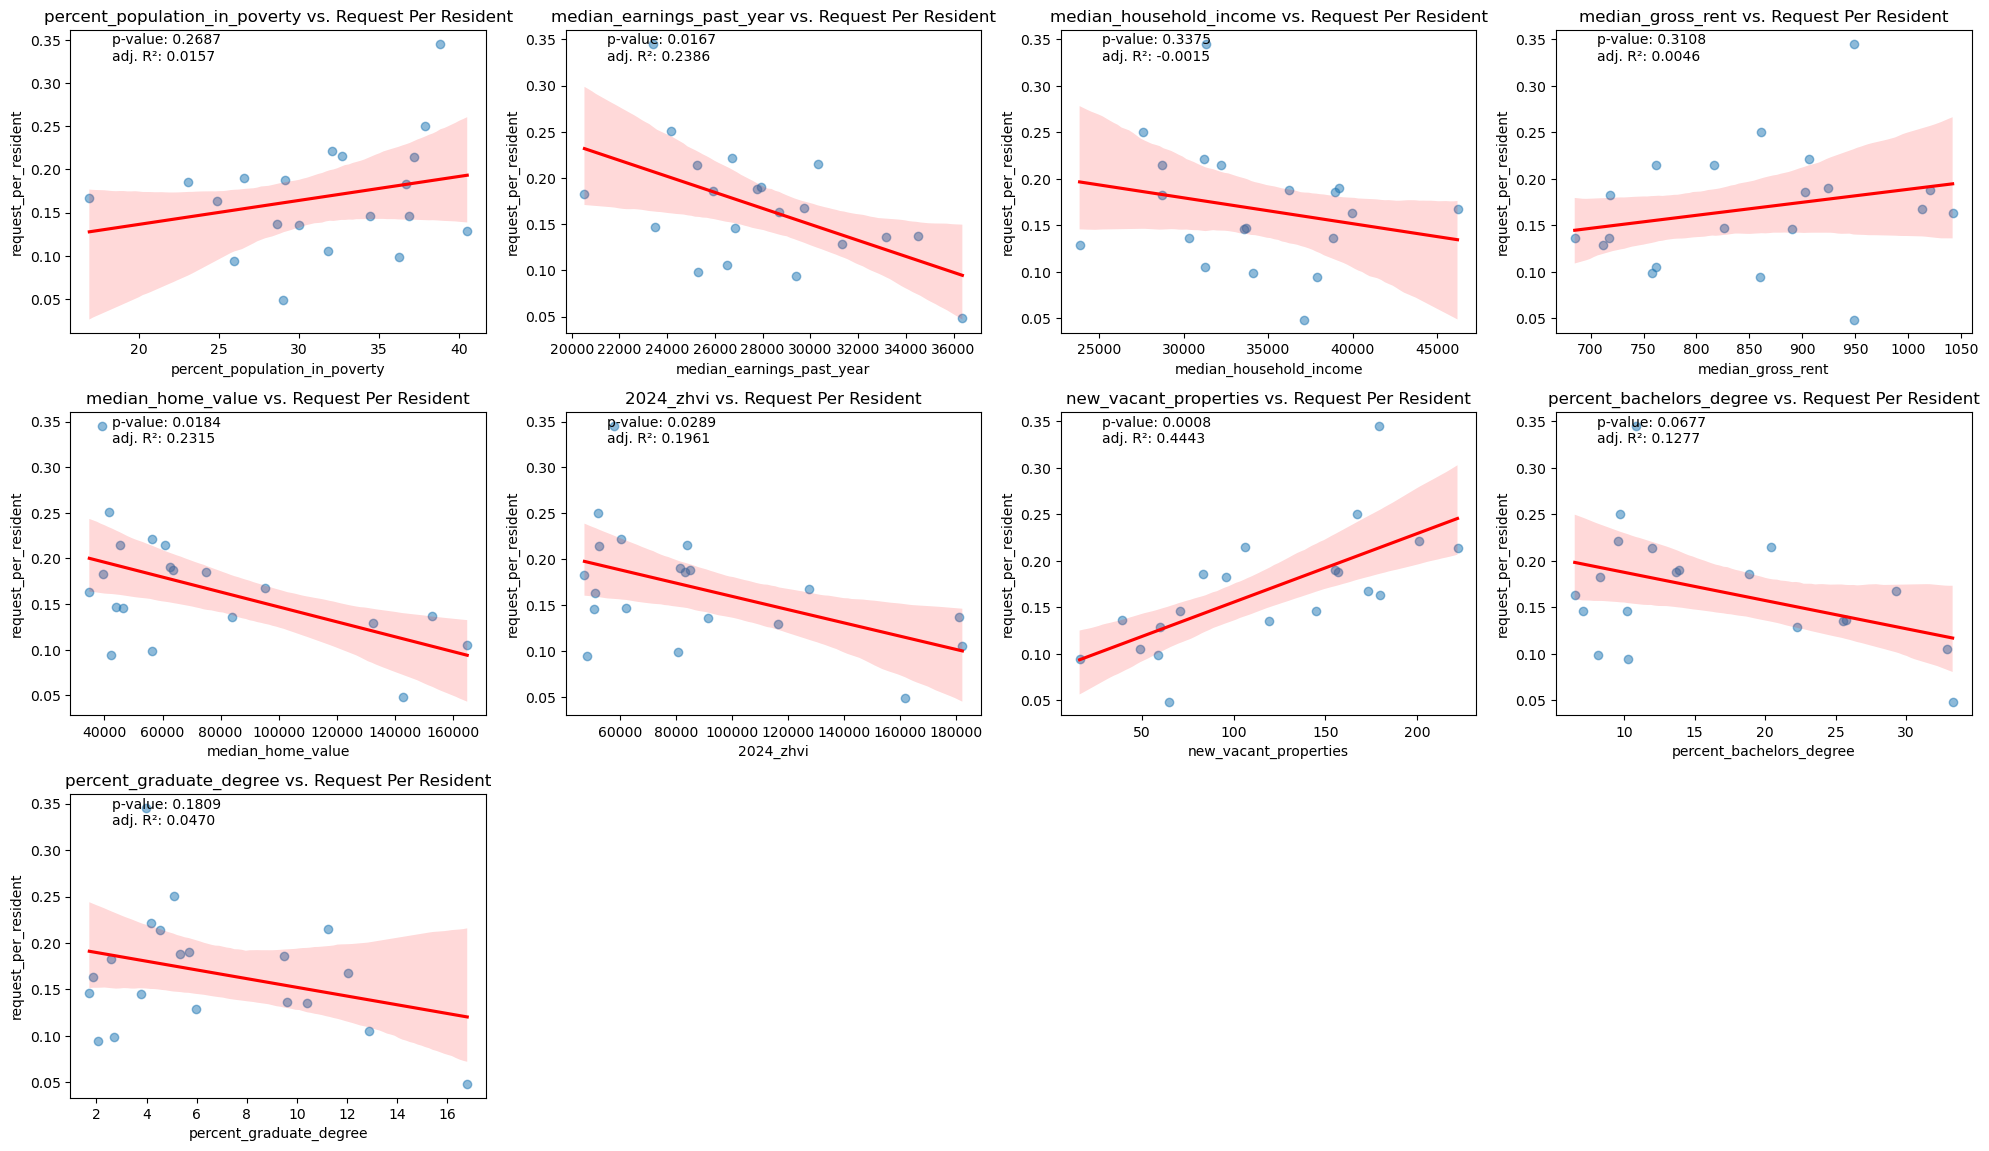

In [79]:
n_rows = 4
n_cols = 4
interesting_variables = [
    'percent_population_in_poverty',
    'median_earnings_past_year', 'median_household_income',
    'median_gross_rent', 'median_home_value','2024_zhvi','new_vacant_properties', 'percent_bachelors_degree',
    'percent_graduate_degree'
]

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
fig.tight_layout(pad=5.0)

for i, column in enumerate(interesting_variables):
    row = i // n_cols
    col = i % n_cols

    # Perform the regression
    X = sm.add_constant(detroit_ip_debris_ses[column]) 
    model = sm.OLS(detroit_ip_debris_ses['request_per_resident'], X).fit()
    p_value = model.pvalues[1]  # Get the p-value for the feature
    adj_r_squared = model.rsquared_adj  # Get the adjusted R-squared value
    
    print(f'{column}: p-vaule {p_value:.4f} adj. R²: {adj_r_squared:.4f}')
    
    # Plot the regplot on the correct subplot
    sns.regplot(x=column, y='request_per_resident', data=detroit_ip_debris_ses, ax=axes[row, col],
                line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})

    axes[row, col].set_title(f'{column} vs. Request Per Resident')

    axes[row, col].text(0.1, 0.9, f'p-value: {p_value:.4f}\nadj. R²: {adj_r_squared:.4f}',
                        transform=axes[row, col].transAxes)

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes.flatten()[j])

# Adjust layout so that it fits well
plt.tight_layout()
plt.show()


| Variables                     | p-value    | Adj R^2    |
|-------------------------------|------------|------------|
| percent_population_in_poverty | 0.2687     | 0.0157     |
| **median_earnings_past_year** | **0.0167** | **0.2386** |
| median_household_income       | 0.3375     | -0.0015    |
| median_gross_rent             | 0.3108     | 0.0046     |
| **median_home_value**         | **0.0184** | **0.2315** |
| **2024_zhvi**                 | **0.0289** | **0.1961** |
| **new_vacant_properties**     | **0.0008** | **0.4443** |
| percent_bachelors_degree      | 0.0677     | 0.1277     |
| percent_graduate_degree       | 0.1809     | 0.0470     |


Observations:

1. I found a strong positive association between the prevalence of new vacant properties and the volume of debris-related service requests, as indicated by a highly significant p-value (0.0008) and the highest adjusted R-squared value (0.4443).
2. Moreover, median earnings from the past year and median home values (and Zillow Home Value Index) also displayed strong statistical significance with their respective p-values. Interestingly, median_household_income is not statistically significant in predicting the average report per resident and has a negative adjusted R^2, whereas median_earnings_past_year is highly significant.
3. Although not as strong, the educational attainment in terms of bachelor’s degrees showed weak statistical significance and positive relationships with request rates, implying that education levels could lead to residents paying more attention to the cleanliness of the environment.

### 3.2 Final Model 

This OLS model predicts the requests per resident using median_earnings_past_year, new_vacant_properties, and the interaction between median_earnings_past_year and new_vacant_properties as predictors. I used a standard scaler for transformation, and it has an adjusted R^2 of 0.613.

In [80]:
detroit_ip_debris_model = detroit_ip_debris_ses
detroit_ip_debris_model.rename(columns={'2024_zhvi': 'zhvi_2024'}, inplace = True)

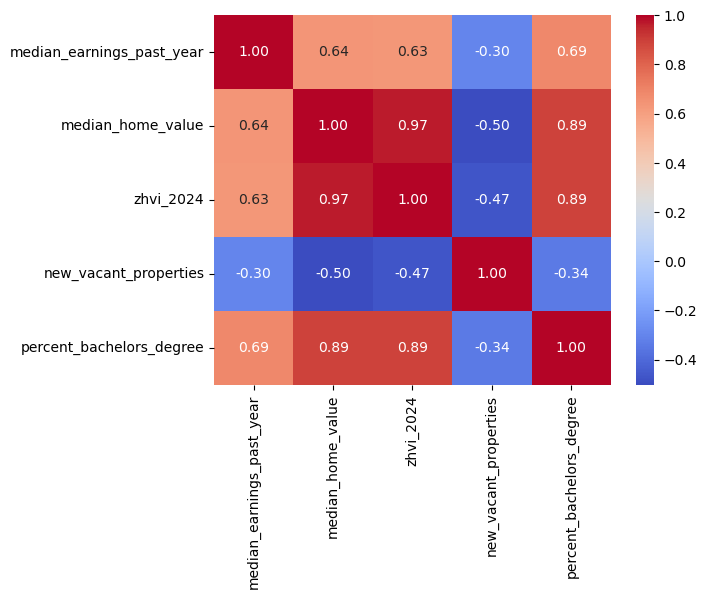

In [81]:
# Analyze correlation using Correlation Matrix
variables = [
    'median_earnings_past_year',
    'median_home_value', 'zhvi_2024', 'new_vacant_properties',
    'percent_bachelors_degree',
]


correlation_matrix = detroit_ip_debris_model[variables].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

# Understandably there is a high correlation between zvhi_2024 and median_home_value. This comes from different measurement of same value. Drop "zvhi_2024" for next step

variables = [
    'median_earnings_past_year',
    'median_home_value', 'new_vacant_properties',
    'percent_bachelors_degree',
]

In [82]:
# Analyze correlation using VIF
X = detroit_ip_debris_model[variables]
variables = sm.add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# There is still a high VIF (>5), indicating issues with multicollinearity. A higher educational level usually translates into better earnings. In the previous section, I found that percent_bachelors_degree is not as statistically significant as the others. I will drop it for the next step.
variables = [
    'median_earnings_past_year',
    'median_home_value', 'new_vacant_properties'
]

                     feature        VIF
0  median_earnings_past_year  18.633561
1          median_home_value  25.932658
2      new_vacant_properties   5.911340
3   percent_bachelors_degree  23.634671


In [83]:
# Analyze correlation using VIF
X = detroit_ip_debris_model[variables]
variables = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

## There is still high VIF (>5) indicating high multiconilairtie issues. Select median_earnings_past_year as it has higher adj R^2
variables = [
    'median_earnings_past_year',
     'new_vacant_properties'
]

                     feature        VIF
0  median_earnings_past_year  18.514031
1          median_home_value   8.503853
2      new_vacant_properties   5.773557


In [84]:
X = detroit_ip_debris_model[variables]
variables = sm.add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     feature       VIF
0  median_earnings_past_year  4.009569
1      new_vacant_properties  4.009569


In [85]:
variables = [
    'median_home_value',
     'new_vacant_properties'
]

X = detroit_ip_debris_model[variables]
variables = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Both are acceptable as correlation problem is addressed (under 5). Let's perform a search to determine the best model.

                 feature       VIF
0      median_home_value  1.841673
1  new_vacant_properties  1.841673


In [86]:
detroit_ip_debris_ses.rename(columns={'2024_zhvi': 'zhvi_2024'}, inplace=True)
variables = ['median_home_value', 'new_vacant_properties', 'median_earnings_past_year']

best_adj_r2 = -float('inf')
best_formula = None

# Generate all possible combinations of variables, including interactions
def generate_formulas(variables):
    formulas = []
    for i in range(1, len(variables) + 1):
        for combo in combinations(variables, i):
            without_interaction = ' + '.join(combo)
            # Include interactions
            for j in range(2, len(combo) + 1):
                for interaction_combo in combinations(combo, j):
                    with_interaction = ' * '.join(interaction_combo)
                    formula = without_interaction + ' + ' + with_interaction
                    formulas.append(formula)            
    return formulas

# Perform exhaustive search
all_formulas = generate_formulas(variables)
for formula in all_formulas:
    # Construct full formula
    full_formula = f'request_per_resident ~ {formula}'
    
    # Fit the model using OLS
    model = smf.ols(full_formula, data=detroit_ip_debris_ses)
    results = model.fit()
    
    # Check if the current model has a better Adj. R-squared
    if results.rsquared_adj > best_adj_r2:
        best_adj_r2 = results.rsquared_adj
        best_formula = full_formula

# Output the best combination and its statistics
print("Best formula:", best_formula)
print("Best Adj. R²:", best_adj_r2)

Best formula: request_per_resident ~ new_vacant_properties + median_earnings_past_year + new_vacant_properties * median_earnings_past_year
Best Adj. R²: 0.6132811065103593


                             OLS Regression Results                             
Dep. Variable:     request_per_resident   R-squared:                       0.674
Model:                              OLS   Adj. R-squared:                  0.613
Method:                   Least Squares   F-statistic:                     11.04
Date:                  Thu, 21 Mar 2024   Prob (F-statistic):           0.000356
Time:                          16:46:24   Log-Likelihood:                 38.072
No. Observations:                    20   AIC:                            -68.14
Df Residuals:                        16   BIC:                            -64.16
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

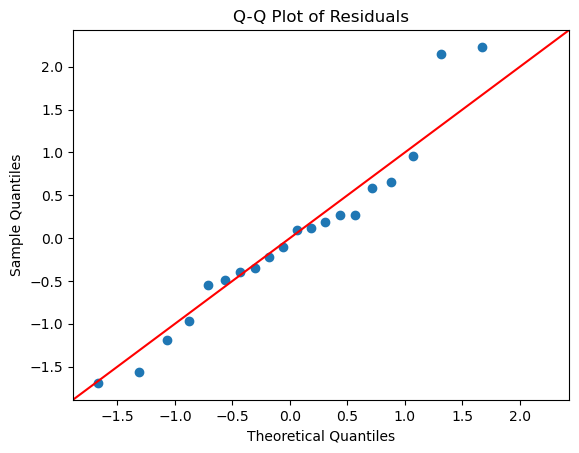

In [87]:
model = smf.ols('request_per_resident ~ new_vacant_properties + median_earnings_past_year + new_vacant_properties:median_earnings_past_year', data=detroit_ip_debris_model).fit()
print(model.summary())

# Generate the Q-Q plot of the residuals
residuals = model.resid
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()